## Perturbation simulation on pancreatic endocrine dataset

## Library imports

In [ ]:
import os
import shutil

import statsmodels.api as sm

In [1]:
from paths import DATA_DIR, FIG_DIR
from regvelo import REGVELOVI

import numpy as np
import pandas as pd
import scipy
from sklearn.metrics import auc, roc_auc_score, roc_curve

import matplotlib.pyplot as plt
import mplscience
import seaborn as sns

import cellrank as cr
import scanpy as sc
import scvelo as scv
import torch
from scvelo import logging as logg
from velovi import VELOVI

2024-08-13 02:09:03.910477: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-13 02:09:08.669787: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-13 02:09:08.670077: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-13 02:09:08.675056: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-13 02:09:09.869740: I tensorflow/core/platform/cpu_feature_g

## General settings

In [2]:
plt.rcParams["svg.fonttype"] = "none"

sns.reset_defaults()
sns.reset_orig()
scv.settings.set_figure_params("scvelo", dpi_save=400, dpi=80, transparent=True, fontsize=14, color_map="viridis")

In [3]:
SAVE_FIGURES = True
if SAVE_FIGURES:
    os.makedirs(FIG_DIR / "pancreatic_endocrine" / "TF_perturbation", exist_ok=True)

SAVE_DATASETS = True
if SAVE_DATASETS:
    os.makedirs(DATA_DIR / "pancreatic_endocrine" / "perturb_repeat_runs", exist_ok=True)
    os.makedirs(DATA_DIR / "pancreatic_endocrine" / "Neurod2_screening_repeat_runs", exist_ok=True)

## Function defination

In [4]:
def min_max_scaling(data):
    """Apply min-max scaling to a numpy array or pandas Series.

    Parameters
    ----------
    data (np.ndarray or pd.Series): The input data to be scaled.

    Returns
    -------
    np.ndarray or pd.Series: Scaled data with values between 0 and 1.
    """
    min_val = np.min(data)
    max_val = np.max(data)

    scaled_data = (data - min_val) / (max_val - min_val)

    return scaled_data


def _in_silico_block_simulation(model, adata, gene, regulation_block=True, target_block=True, effects=0, cutoff=1e-3):
    """TODO."""
    reg_vae_perturb = REGVELOVI.load(model, adata)
    perturb_GRN = reg_vae_perturb.module.v_encoder.fc1.weight.detach().clone()

    if regulation_block:
        perturb_GRN[
            (perturb_GRN[:, [i == gene for i in adata.var.index]].abs() > cutoff).cpu().numpy().reshape(-1),
            [i == gene for i in adata.var.index],
        ] = effects
    if target_block:
        perturb_GRN[
            [i == gene for i in adata_target.var.index],
            (perturb_GRN[[i == gene for i in adata_target.var.index], :].abs() > 1e-3).cpu().numpy().reshape(-1),
        ] = effects

    reg_vae_perturb.module.v_encoder.fc1.weight.data = perturb_GRN
    adata_target_perturb = add_regvelo_outputs_to_adata(adata, reg_vae_perturb)

    return adata_target_perturb, reg_vae_perturb


def add_regvelo_outputs_to_adata(adata_raw, vae, n_samples=30):
    """TODO."""
    latent_time = vae.get_latent_time(n_samples=n_samples, time_statistic="mean", batch_size=adata_raw.shape[0])
    velocities = vae.get_velocity(n_samples=n_samples, velo_statistic="mean", batch_size=adata_raw.shape[0])

    t = latent_time
    scaling = 20 / t.max(0)
    adata = adata_raw[:, vae.module.target_index].copy()

    adata.layers["velocity"] = velocities / scaling
    adata.layers["latent_time_regvelo"] = latent_time

    adata.layers["fit_t"] = latent_time.values * scaling[np.newaxis, :]
    adata.var["fit_scaling"] = 1.0

    return adata


def _in_silico_block_regulation_simulation(model, adata, regulator, target, effects=0):
    """TODO."""
    reg_vae_perturb = REGVELOVI.load(model, adata)
    perturb_GRN = reg_vae_perturb.module.v_encoder.fc1.weight.detach().clone()

    perturb_GRN[
        [i == target for i in adata_target.var.index], [i == regulator for i in adata_target.var.index]
    ] = effects

    reg_vae_perturb.module.v_encoder.fc1.weight.data = perturb_GRN
    adata_target_perturb = add_regvelo_outputs_to_adata(adata, reg_vae_perturb, n_samples=50)

    return adata_target_perturb


def add_outputs_to_adata(adata, vae):
    """TODO."""
    latent_time = vae.get_latent_time(n_samples=25)
    velocities = vae.get_velocity(n_samples=25, velo_statistic="mean")

    t = latent_time
    scaling = 20 / t.max(0)

    adata.layers["velocity"] = velocities / scaling
    adata.layers["latent_time_velovi"] = latent_time

    adata.var["fit_alpha"] = vae.get_rates()["alpha"] / scaling
    adata.var["fit_beta"] = vae.get_rates()["beta"] / scaling
    adata.var["fit_gamma"] = vae.get_rates()["gamma"] / scaling
    adata.var["fit_t_"] = (
        torch.nn.functional.softplus(vae.module.switch_time_unconstr).detach().cpu().numpy()
    ) * scaling
    adata.layers["fit_t"] = latent_time.values * scaling[np.newaxis, :]
    adata.var["fit_scaling"] = 1.0

In [5]:
def threshold_top_k(tensor, k):
    """TODO."""
    # Flatten the tensor
    flattened_tensor = tensor.flatten()

    # Get the indices of the top k positive and negative values
    _, top_k_pos_indices = torch.topk(flattened_tensor, k)
    _, top_k_neg_indices = torch.topk(-flattened_tensor, k)

    # Create a mask for the top k positive and negative values
    mask = torch.zeros_like(flattened_tensor, dtype=torch.float)
    mask[top_k_pos_indices] = 1
    mask[top_k_neg_indices] = 1

    # Reshape the mask to the original tensor shape
    mask = mask.view(tensor.shape)

    return mask


def p_adjust_bh(p):
    """TODO."""
    p = np.asfarray(p)
    by_descend = p.argsort()[::-1]
    by_orig = by_descend.argsort()
    steps = float(len(p)) / np.arange(len(p), 0, -1)
    q = np.minimum(1, np.minimum.accumulate(steps * p[by_descend]))
    return q[by_orig]


def abundance_test(prob_raw, prob_pert, correction=True, method="p"):
    """TODO."""
    y = [0] * prob_raw.shape[0] + [1] * prob_pert.shape[0]
    X = pd.concat([prob_raw, prob_pert], 0)

    table = []
    for i in range(prob_raw.shape[1]):
        pred = X.iloc[:, i]
        var = X.iloc[:, [j != i for j in range(prob_raw.shape[1])]]
        # var = sm.add_constant(var)
        est = sm.OLS(pred, var)
        est.fit()
        # pred = pred - est2.predict(var)
        # pred = pred - est2.predict(var)
        # pred = scipy.stats.zscore(pred)
        # pred = np.log(pred * 100 + 0.01)
        if method == "p":
            table.append(np.expand_dims(np.array(list(scipy.stats.pearsonr(pred, y))), 0))
        if method == "sp":
            table.append(np.expand_dims(np.array(list(scipy.stats.spearmanr(pred, y))), 0))

    table = np.concatenate(table, 0)
    table = pd.DataFrame(table)
    table.index = prob_raw.columns
    table.columns = ["coefficient", "p-value"]
    ## Running FDR addjust
    table.loc[:, "FDR adjusted p-value"] = p_adjust_bh(table.loc[:, "p-value"].tolist())

    return table


def get_list_name(lst):
    """TODO."""
    names = []
    for name, _obj in lst.items():
        names.append(name)
    return names


def TFScanning(model_path, adata, n_states, cluster_label, terminal_states, TF, effect):
    """TODO."""
    reg_vae = REGVELOVI.load(model_path, adata)
    # reg_vae.module = reg_vae.module.cpu()
    adata = add_regvelo_outputs_to_adata(adata, reg_vae)
    raw_GRN = reg_vae.module.v_encoder.fc1.weight.detach().clone()
    perturb_GRN = reg_vae.module.v_encoder.fc1.weight.detach().clone()
    ## curated all targets of specific TF
    raw_GRN.sum(0)
    # TF = adata.var.index[weight != 0].tolist()
    vk = cr.kernels.VelocityKernel(adata)
    vk.compute_transition_matrix()
    ck = cr.kernels.ConnectivityKernel(adata).compute_transition_matrix()
    combined_kernel = 0.8 * vk + 0.2 * ck
    g2 = cr.estimators.GPCCA(combined_kernel)
    ## evaluate the fate prob on original space

    g2.compute_macrostates(n_states=n_states, n_cells=30, cluster_key=cluster_label)
    # set a high number of states, and merge some of them and rename
    if terminal_states is None:
        g2.predict_terminal_states()
        terminal_states = g2.terminal_states.cat.categories.tolist()
    g2.set_terminal_states(terminal_states)
    # g2 = g2.rename_terminal_states({"Mono_1": "Mono","DCs_1":"DC"})
    g2.compute_fate_probabilities(solver="direct")
    fate_prob = g2.fate_probabilities
    sampleID = adata.obs.index.tolist()
    fate_name = fate_prob.names.tolist()
    fate_prob = pd.DataFrame(fate_prob, index=sampleID, columns=fate_name)
    fate_prob_original = fate_prob.copy()
    ## create dictionary
    terminal_id = terminal_states.copy()
    terminal_type = terminal_states.copy()
    for i in terminal_states:
        for j in [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]:
            terminal_id.append(i + "_" + str(j))
            terminal_type.append(i)
    dict(zip(terminal_id, terminal_type))
    n_states = len(g2.macrostates.cat.categories.tolist())
    coef = []
    pvalue = []
    for tf in TF:
        perturb_GRN = raw_GRN.clone()
        # perturb_GRN[:,[i in tf for i in adata.var.index.tolist()]] = 0
        vec = perturb_GRN[:, [i in tf for i in adata.var.index.tolist()]].clone()
        vec[vec.abs() > 1e-3] = 0
        perturb_GRN[:, [i in tf for i in adata.var.index.tolist()]] = vec
        reg_vae_perturb = REGVELOVI.load(model_path, adata)
        reg_vae_perturb.module.v_encoder.fc1.weight.data = perturb_GRN

        adata_target = add_regvelo_outputs_to_adata(adata, reg_vae_perturb)
        ## perturb the regulations
        vk = cr.kernels.VelocityKernel(adata_target)
        vk.compute_transition_matrix()
        ck = cr.kernels.ConnectivityKernel(adata_target).compute_transition_matrix()
        combined_kernel = 0.8 * vk + 0.2 * ck
        g2 = cr.estimators.GPCCA(combined_kernel)
        ## evaluate the fate prob on original space
        n_states_perturb = n_states
        while True:
            try:
                # Perform some computation in f(a)
                g2.compute_macrostates(n_states=n_states_perturb, n_cells=30, cluster_key=cluster_label)
                # If no error is raised, break the loop and return the result
                # g2.set_terminal_states(
                #    terminal_states
                # )
                break
            except:
                # If an error is raised, increment a and try again, and need to recompute double knock-out reults
                n_states_perturb += 1
                vk = cr.kernels.VelocityKernel(adata)
                vk.compute_transition_matrix()
                ck = cr.kernels.ConnectivityKernel(adata).compute_transition_matrix()
                g = cr.estimators.GPCCA(0.8 * vk + 0.2 * ck)
                ## evaluate the fate prob on original space
                g.compute_macrostates(n_states=n_states_perturb, n_cells=30, cluster_key=cluster_label)
                ## set a high number of states, and merge some of them and rename
                if terminal_states is None:
                    g.predict_terminal_states()
                    terminal_states = g.terminal_states.cat.categories.tolist()
                g.set_terminal_states(terminal_states)
                # g2 = g2.rename_terminal_states({"Mono_1": "Mono","DCs_1":"DC"})
                g.compute_fate_probabilities(solver="direct")
                fate_prob = g.fate_probabilities
                sampleID = adata.obs.index.tolist()
                fate_name = fate_prob.names.tolist()
                fate_prob = pd.DataFrame(fate_prob, index=sampleID, columns=fate_name)
                raise

        ## intersection the states
        terminal_states_perturb = g2.macrostates.cat.categories.tolist()

        # terminal_states_perturb = list(set(terminal_states_perturb).intersection(terminal_id))
        terminal_states_perturb = list(set(terminal_states_perturb).intersection(terminal_states))

        # subset_dict = {key: terminal_dict[key] for key in terminal_states_perturb}
        # terminal_states_perturb_names = list(subset_dict.values())
        ## check if all terminal state is coverred
        # if len(set(terminal_states_perturb_names).intersection(terminal_states)) != len(terminal_states):
        #    ValueError("Terminal states are not recoverred in perturbation, please increase the number of the states!")

        g2.set_terminal_states(terminal_states_perturb)
        g2.compute_fate_probabilities(solver="direct")
        fb = g2.fate_probabilities
        sampleID = adata.obs.index.tolist()
        fate_name = fb.names.tolist()
        fb = pd.DataFrame(fb, index=sampleID, columns=fate_name)
        fate_prob2 = pd.DataFrame(columns=terminal_states, index=sampleID)

        for i in terminal_states_perturb:
            # fate_prob2.loc[:,i] = fb.loc[:,[j == i for j in terminal_states_perturb_names]].sum(1).tolist()
            fate_prob2.loc[:, i] = fb.loc[:, i]

        fate_prob2 = fate_prob2.fillna(0)
        arr = np.array(fate_prob2.sum(0))
        arr[arr != 0] = 1
        fate_prob = fate_prob * arr

        [0] * fate_prob.shape[0] + [1] * fate_prob2.shape[0]
        fate_prob2.index = [i + "_perturb" for i in fate_prob2.index]
        test_result = abundance_test(fate_prob, fate_prob2)
        coef.append(test_result.loc[:, "coefficient"])
        pvalue.append(test_result.loc[:, "FDR adjusted p-value"])
        logg.info("Done " + tf)
        fate_prob = fate_prob_original.copy()
    d = {"TF": TF, "coefficient": coef, "pvalue": pvalue}
    # df = pd.DataFrame(data=d)
    return d


### Perform perturbation benchmark
def RegulationScanning(model_path, adata, n_states, cluster_label, terminal_states, TF, target, effect):
    """TODO."""
    reg_vae = REGVELOVI.load(model_path, adata)
    # reg_vae.module = reg_vae.module.cpu()
    adata = add_regvelo_outputs_to_adata(adata, reg_vae, n_samples=50)
    raw_GRN = reg_vae.module.v_encoder.fc1.weight.detach().clone()
    reg_vae.module.v_encoder.fc1.weight.detach().clone()
    ## curated all targets of specific TF
    raw_GRN.sum(0)
    # TF = adata.var.index[weight != 0].tolist()
    vk = cr.kernels.VelocityKernel(adata)
    vk.compute_transition_matrix()
    ck = cr.kernels.ConnectivityKernel(adata).compute_transition_matrix()
    combined_kernel = 0.8 * vk + 0.2 * ck
    g2 = cr.estimators.GPCCA(combined_kernel)
    ## evaluate the fate prob on original space

    g2.compute_macrostates(n_states=n_states, n_cells=30, cluster_key=cluster_label)
    # set a high number of states, and merge some of them and rename
    if terminal_states is None:
        g2.predict_terminal_states()
        terminal_states = g2.terminal_states.cat.categories.tolist()
    g2.set_terminal_states(terminal_states)
    # g2 = g2.rename_terminal_states({"Mono_1": "Mono","DCs_1":"DC"})
    g2.compute_fate_probabilities(solver="direct")
    fate_prob = g2.fate_probabilities
    sampleID = adata.obs.index.tolist()
    fate_name = fate_prob.names.tolist()
    fate_prob = pd.DataFrame(fate_prob, index=sampleID, columns=fate_name)
    fate_prob_original = fate_prob.copy()
    ## create dictionary
    terminal_id = terminal_states.copy()
    terminal_type = terminal_states.copy()
    for i in terminal_states:
        for j in [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]:
            terminal_id.append(i + "_" + str(j))
            terminal_type.append(i)
    terminal_dict = dict(zip(terminal_id, terminal_type))
    n_states = len(g2.macrostates.cat.categories.tolist())
    coef = []
    pvalue = []
    for gene in target:
        adata_target = _in_silico_block_regulation_simulation(model, reg_bdata, TF, gene, effects=0)

        ## perturb the regulations
        vk = cr.kernels.VelocityKernel(adata_target)
        vk.compute_transition_matrix()
        ck = cr.kernels.ConnectivityKernel(adata_target).compute_transition_matrix()
        combined_kernel = 0.8 * vk + 0.2 * ck
        g2 = cr.estimators.GPCCA(combined_kernel)
        ## evaluate the fate prob on original space
        n_states_perturb = n_states
        while True:
            try:
                # Perform some computation in f(a)
                g2.compute_macrostates(n_states=n_states_perturb, n_cells=30, cluster_key=cluster_label)
                # If no error is raised, break the loop and return the result
                break
            except:
                # If an error is raised, increment a and try again, and need to recompute double knock-out reults
                n_states_perturb += 1
                vk = cr.kernels.VelocityKernel(adata)
                vk.compute_transition_matrix()
                # ck = cr.kernels.ConnectivityKernel(adata).compute_transition_matrix()
                g = cr.estimators.GPCCA(0.8 * vk + 0.2 * ck)
                ## evaluate the fate prob on original space
                g.compute_macrostates(n_states=n_states_perturb, n_cells=30, cluster_key=cluster_label)
                ## set a high number of states, and merge some of them and rename
                if terminal_states is None:
                    g.predict_terminal_states()
                    terminal_states = g.terminal_states.cat.categories.tolist()
                g.set_terminal_states(terminal_states)
                # g2 = g2.rename_terminal_states({"Mono_1": "Mono","DCs_1":"DC"})
                g.compute_fate_probabilities(solver="direct")
                fate_prob = g.fate_probabilities
                sampleID = adata.obs.index.tolist()
                fate_name = fate_prob.names.tolist()
                fate_prob = pd.DataFrame(fate_prob, index=sampleID, columns=fate_name)
                raise

        ## intersection the states
        terminal_states_perturb = g2.macrostates.cat.categories.tolist()
        terminal_states_perturb = list(set(terminal_states_perturb).intersection(terminal_id))
        subset_dict = {key: terminal_dict[key] for key in terminal_states_perturb}
        terminal_states_perturb_names = list(subset_dict.values())
        ## check if all terminal state is coverred
        if len(set(terminal_states_perturb_names).intersection(terminal_states)) != len(terminal_states):
            ValueError("Terminal states are not recoverred in perturbation, please increase the number of the states!")
        g2.set_terminal_states(terminal_states_perturb)
        g2.compute_fate_probabilities(solver="direct")
        fb = g2.fate_probabilities
        sampleID = adata.obs.index.tolist()
        fate_name = fb.names.tolist()
        fb = pd.DataFrame(fb, index=sampleID, columns=fate_name)
        fate_prob2 = pd.DataFrame(columns=terminal_states, index=sampleID)
        for i in terminal_states:
            fate_prob2.loc[:, i] = fb.loc[:, [j == i for j in terminal_states_perturb_names]].sum(1).tolist()
        [0] * fate_prob.shape[0] + [1] * fate_prob2.shape[0]
        fate_prob2.index = [i + "_perturb" for i in fate_prob2.index]
        test_result = abundance_test(fate_prob, fate_prob2)
        coef.append(test_result.loc[:, "coefficient"])
        pvalue.append(test_result.loc[:, "FDR adjusted p-value"])
        logg.info("Done " + gene)
        fate_prob = fate_prob_original.copy()
    d = {"target": target, "coefficient": coef, "pvalue": pvalue}
    # df = pd.DataFrame(data=d)
    return d

In [6]:
def cal_cell_fate(adata, terminal_states, cluster_key, n_states=7):
    """TODO."""
    terminal_id = terminal_states.copy()
    terminal_type = terminal_states.copy()
    for i in terminal_states:
        for j in [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]:
            terminal_id.append(i + "_" + str(j))
            terminal_type.append(i)
    terminal_dict = dict(zip(terminal_id, terminal_type))

    vk = cr.kernels.VelocityKernel(adata).compute_transition_matrix()
    ck = cr.kernels.ConnectivityKernel(adata).compute_transition_matrix()
    combined_kernel = 0.8 * vk + 0.2 * ck
    g2 = cr.estimators.GPCCA(combined_kernel)

    ## evaluate the fate prob on original space
    g2.compute_macrostates(n_states=n_states, n_cells=30, cluster_key=cluster_key)
    ## set a high number of states, and merge some of them and rename
    terminal_states_perturb = g2.macrostates.cat.categories.tolist()
    terminal_states_perturb = list(set(terminal_states_perturb).intersection(terminal_id))
    subset_dict = {key: terminal_dict[key] for key in terminal_states_perturb}
    terminal_states_perturb_names = list(subset_dict.values())
    ## check if all terminal state is coverred
    if len(set(terminal_states_perturb_names).intersection(terminal_states)) != len(terminal_states):
        ValueError("Terminal states are not recoverred in perturbation, please increase the number of the states!")
    g2.set_terminal_states(terminal_states_perturb)
    g2.compute_fate_probabilities(solver="direct")
    fb = g2.fate_probabilities
    sampleID = adata.obs.index.tolist()
    fate_name = fb.names.tolist()
    fb = pd.DataFrame(fb, index=sampleID, columns=fate_name)
    fate_prob2 = pd.DataFrame(columns=terminal_states, index=sampleID)
    for i in terminal_states:
        fate_prob2.loc[:, i] = fb.loc[:, [j == i for j in terminal_states_perturb_names]].sum(1).tolist()

    return fate_prob2

In [7]:
def plot_perm_scores(coef, adata, color_label, gene_name, figsize=(6, 4)):
    """TODO."""
    df = pd.DataFrame(coef.loc[gene_name, :])
    df.columns = ["coefficient"]
    df["Cell type"] = coef.columns.tolist()
    order = coef.columns.tolist()

    palette = dict(zip(adata.obs[color_label].cat.categories, adata.uns[f"{color_label}_colors"]))
    subset_palette = {name: color for name, color in palette.items() if name in coef.columns.tolist()}

    with mplscience.style_context():
        sns.set_style(style="whitegrid")
        fig, ax = plt.subplots(figsize=figsize)
        sns.barplot(
            data=df,
            y="coefficient",
            x="Cell type",
            palette=subset_palette,
            order=order,
            ax=ax,
        )
        # ax.set(ylim=(-2.1,2.1))
        ax.tick_params(axis="x", rotation=90)
        plt.title("$\\mathit{" + gene_name + "}$ regulon knock out simulation")

    if SAVE_FIGURES:
        save_path = "Identifiability_Benchmark_" + gene_name + ".svg"
        fig.savefig(
            FIG_DIR / "pancreatic_endocrine" / "TF_perturbation" / save_path,
            format="svg",
            transparent=True,
            bbox_inches="tight",
        )

## Data loading

In [8]:
TF = pd.read_csv("RegVelo_datasets/pancreatic endocrine/allTFs_mm.txt", header=None)
reg_bdata = sc.read_h5ad(DATA_DIR / "pancreatic_endocrine" / "reg_bdata.h5ad")

In [9]:
TF_list = list(set(TF.iloc[:, 0].tolist()).intersection(reg_bdata.var_names))

In [10]:
W = reg_bdata.uns["skeleton"].copy()
W = torch.tensor(np.array(W)).int()

## Repeat model to simulate perturbation effects

In [11]:
terminal_states = ["Alpha", "Delta", "Beta", "Epsilon"]
for nrun in range(0, 25):
    print("training model...")
    REGVELOVI.setup_anndata(reg_bdata, spliced_layer="Ms", unspliced_layer="Mu")
    reg_vae2 = REGVELOVI(reg_bdata, W=W.T, regulators=TF.iloc[:, 0].tolist())
    reg_vae2.train()

    print("save model...")

    model_name = "rgv_model_" + str(nrun)
    coef_name = "coef_" + str(nrun)
    pval_name = "pval_" + str(nrun)

    model = DATA_DIR / "pancreatic_endocrine" / "perturb_repeat_runs" / model_name
    coef_save = DATA_DIR / "pancreatic_endocrine" / "perturb_repeat_runs" / coef_name
    pval_save = DATA_DIR / "pancreatic_endocrine" / "perturb_repeat_runs" / pval_name

    reg_vae2.save(model)

    print("inferring perturbation...")

    while True:
        try:
            perturb_screening = TFScanning(model, reg_bdata, 8, "clusters", terminal_states, TF_list, 0)
            coef = pd.DataFrame(np.array(perturb_screening["coefficient"]))
            coef.index = perturb_screening["TF"]
            coef.columns = get_list_name(perturb_screening["coefficient"][0])
            coef.to_csv(coef_save)

            pval = pd.DataFrame(np.array(perturb_screening["pvalue"]))
            pval.index = perturb_screening["TF"]
            pval.columns = get_list_name(perturb_screening["pvalue"][0])
            pval.to_csv(pval_save)

            rows_with_nan = coef.isna().any(axis=1)
            # Set all values in those rows to NaN
            coef.loc[rows_with_nan, :] = np.nan
            pval.loc[rows_with_nan, :] = np.nan

            break
        except:
            # If an error is raised, increment a and try again, and need to recompute double knock-out reults
            print("perturbation screening has error, retraining model...")
            shutil.rmtree(model)
            REGVELOVI.setup_anndata(reg_bdata, spliced_layer="Ms", unspliced_layer="Mu")
            reg_vae2 = REGVELOVI(reg_bdata, W=W.T, regulators=TF.iloc[:, 0].tolist())
            reg_vae2.train()
            print("save model...")
            reg_vae2.save(model)
            raise

training model...


/home/icb/weixu.wang/miniconda3/envs/RegVelo/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/RegVelo/lib/pyt ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/icb/weixu.wang/miniconda3/envs/RegVelo/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/RegVelo/lib/pyt ...
  rank_zero_warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/

Epoch 1500/1500: 100%|██████████| 1500/1500 [29:34<00:00,  1.18s/it, loss=-2.34e+03, v_num=1]

`Trainer.fit` stopped: `max_epochs=1500` reached.


Epoch 1500/1500: 100%|██████████| 1500/1500 [29:34<00:00,  1.18s/it, loss=-2.34e+03, v_num=1]
save model...
inferring perturbation...
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_0/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_0/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.


  0%|          | 0/3696 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.


Done Cdk2ap1
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_0/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.


  0%|          | 0/3696 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.


Done Gpd1
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_0/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.


  0%|          | 0/3696 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.


Done Foxa2
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_0/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.


  0%|          | 0/3696 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.


Done Neurod1
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_0/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 


  0%|          | 0/3696 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 


Done Celf4
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_0/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.


  0%|          | 0/3696 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.


Done Hhex
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_0/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.


  0%|          | 0/3696 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.


Done Nkx2-2
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_0/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.


  0%|          | 0/3696 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 11 SEGV: Segmentation Violation, probably memory access out of range
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
[0]PE

Done Tff3
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_0/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Hmgb2
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_0/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Pdx1
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_0/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.


  0%|          | 0/3696 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 11 SEGV: Segmentation Violation, probably memory access out of range
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
[0]PE

Done Sox9
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_0/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.


  0%|          | 0/3696 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.


Done Tagln2
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_0/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.


  0%|          | 0/3696 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.


Done Fosb
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_0/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.


  0%|          | 0/3696 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.


Done Klf7
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_0/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.


  0%|          | 0/3696 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: 

Done Stat3
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_0/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.


  0%|          | 0/3696 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.


Done Mlxipl
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_0/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.


  0%|          | 0/3696 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: [0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 11 SEGV: Segmentation Violation, probably memory access out of range
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: 

Done Hes1
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_0/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Zbtb20
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_0/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 11 SEGV: Segmentation Violation, probably memory access out of range
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
[0]PE

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done A1cf
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_0/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Irx2
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_0/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 11 SEGV: Segmentation Violation, probably memory access out of range
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
[0]PETSC ERROR: Run with -malloc_debug to check if memory corruption is causing the crash.


Done Hdac6
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_0/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.


  0%|          | 0/3696 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 11 SEGV: Segmentation Violation, probably memory access out of range
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
[0]PE

Done E2f1
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_0/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.


  0%|          | 0/3696 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.


Done Prdm16
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_0/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.


  0%|          | 0/3696 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 11 SEGV: Segmentation Violation, probably memory access out of range
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
[0]PE

Done Foxo3
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_0/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
realloc(): invalid old size


  0%|          | 0/3696 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.


Done Hmgb3
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_0/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.


  0%|          | 0/3696 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.


Done Zbtb7c
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_0/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.


  0%|          | 0/3696 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.


Done Klf6
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_0/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.


  0%|          | 0/3696 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------


Done Zfp174
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_0/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.


  0%|          | 0/3696 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.


Done Neurod2
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_0/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Dach1
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_0/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Crem
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_0/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.


Done Rbpjl
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_0/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.


  0%|          | 0/3696 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.


Done Ikzf4
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_0/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.


  0%|          | 0/3696 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 11 SEGV: Segmentation Violation, probably memory access out of range
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
[0]PE

Done Foxa3
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_0/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.


  0%|          | 0/3696 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.


Done Meis2
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_0/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 11 SEGV: Segmentation Violation, probably memory access out of range
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
[0]PE

  0%|          | 0/3696 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.


Done Foxo1
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_0/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.


  0%|          | 0/3696 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.


Done Srrm3
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_0/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.


  0%|          | 0/3696 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.


Done Fhl2
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_0/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: 

  0%|          | 0/3696 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.


Done Hes6
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_0/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.


  0%|          | 0/3696 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 11 SEGV: Segmentation Violation, probably memory access out of range
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
[0]PE

Done Cat
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_0/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.


  0%|          | 0/3696 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 11 SEGV: Segmentation Violation, probably memory access out of range
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
[0]PE

Done Etv1
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_0/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.


  0%|          | 0/3696 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.


Done Gadd45a
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_0/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

[0]PETSC ERROR: 

  0%|          | 0/3696 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.


Done Id2
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_0/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 11 SEGV: Segmentation Violation, probably memory access out of range
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
[0]PE

  0%|          | 0/3696 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 11 SEGV: Segmentation Violation, probably memory access out of range
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
[0]PE

Done Atf3
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_0/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done H2afz
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_0/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Mctp2
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_0/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.


  0%|          | 0/3696 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.


Done Isl1
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_0/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.


  0%|          | 0/3696 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.


Done Zfp516
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_0/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.


  0%|          | 0/3696 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.


Done Zfhx2
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_0/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.


  0%|          | 0/3696 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: 

Done Tead2
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_0/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.


  0%|          | 0/3696 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 11 SEGV: Segmentation Violation, probably memory access out of range
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
[0]PE

Done Sim1
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_0/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.


  0%|          | 0/3696 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 11 SEGV: Segmentation Violation, probably memory access out of range
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
[0]PE

Done Tgif1
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_0/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: [0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 11 SEGV: Segmentation Violation, probably memory access out of range
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: 

  0%|          | 0/3696 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.


Done Hsf2
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_0/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.


  0%|          | 0/3696 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.


Done Nkx6-1
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_0/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.


  0%|          | 0/3696 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.


Done Mycl
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_0/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 11 SEGV: Segmentation Violation, probably memory access out of range
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
[0]PE

  0%|          | 0/3696 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.


Done Rfx6
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_0/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.


  0%|          | 0/3696 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.


Done Nfix
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_0/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------


  0%|          | 0/3696 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.


Done Mnx1
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_0/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.


  0%|          | 0/3696 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.


Done Nuak2
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_0/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Hmga2
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_0/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Smarca1
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_0/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.


  0%|          | 0/3696 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.


Done Pax4
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_0/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.


  0%|          | 0/3696 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 11 SEGV: Segmentation Violation, probably memory access out of range
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
[0]PE

Done Msi1
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_0/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.


  0%|          | 0/3696 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.


Done Fos
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_0/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.


  0%|          | 0/3696 [00:00<?, ?cell/s]

[0]PETSC ERROR: 

Done Arx
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_0/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: 

  0%|          | 0/3696 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: 

Done Rest
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_0/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 11 SEGV: Segmentation Violation, probably memory access out of range
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
[0]PE

  0%|          | 0/3696 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.


Done Fev
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_0/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 11 SEGV: Segmentation Violation, probably memory access out of range
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
[0]PE

  0%|          | 0/3696 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger


Done Vdr
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_0/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.


  0%|          | 0/3696 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.


Done Atoh8
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_0/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.


  0%|          | 0/3696 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.


Done Npdc1
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_0/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Pax6
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_0/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Kif22
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_0/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger


Done Ebf1
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_0/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 11 SEGV: Segmentation Violation, probably memory access out of range
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
[0]PE

  0%|          | 0/3696 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.


Done Foxp2
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_0/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.


  0%|          | 0/3696 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 11 SEGV: Segmentation Violation, probably memory access out of range
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
[0]PE

Done Hspa5
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_0/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.


  0%|          | 0/3696 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.


Done Nfib
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_0/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 11 SEGV: Segmentation Violation, probably memory access out of range
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
[0]PE

  0%|          | 0/3696 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.


Done Etv5
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_0/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.


  0%|          | 0/3696 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.


Done Pou6f2
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_0/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.


  0%|          | 0/3696 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.


Done Irx1
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_0/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.


  0%|          | 0/3696 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.


Done Lmx1b
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_0/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.


  0%|          | 0/3696 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.


Done Arg1
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_0/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.


  0%|          | 0/3696 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 11 SEGV: Segmentation Violation, probably memory access out of range
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
[0]PE

Done Cbfa2t2
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_0/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Nr4a2
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_0/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Nr4a1
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_0/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.


  0%|          | 0/3696 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.


Done Zbtb10
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_0/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 11 SEGV: Segmentation Violation, probably memory access out of range
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
[0]PE

  0%|          | 0/3696 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.


Done Neurog3
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_0/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 


  0%|          | 0/3696 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.


Done Ehf
training model...


/home/icb/weixu.wang/miniconda3/envs/RegVelo/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/RegVelo/lib/pyt ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/icb/weixu.wang/miniconda3/envs/RegVelo/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/RegVelo/lib/pyt ...
  rank_zero_warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/

Epoch 1500/1500: 100%|██████████| 1500/1500 [29:47<00:00,  1.19s/it, loss=-2.35e+03, v_num=1]

`Trainer.fit` stopped: `max_epochs=1500` reached.


Epoch 1500/1500: 100%|██████████| 1500/1500 [29:47<00:00,  1.19s/it, loss=-2.35e+03, v_num=1]
save model...
inferring perturbation...
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_1/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_1/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Cdk2ap1
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_1/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Gpd1
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_1/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Foxa2
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_1/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Neurod1
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_1/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Celf4
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_1/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Hhex
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_1/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Nkx2-2
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_1/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Tff3
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_1/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Hmgb2
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_1/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Pdx1
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_1/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Sox9
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_1/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Tagln2
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_1/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Fosb
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_1/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Klf7
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_1/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Stat3
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_1/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Mlxipl
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_1/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Hes1
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_1/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Zbtb20
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_1/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done A1cf
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_1/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Irx2
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_1/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Hdac6
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_1/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done E2f1
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_1/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Prdm16
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_1/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Foxo3
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_1/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Hmgb3
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_1/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Zbtb7c
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_1/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Klf6
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_1/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Zfp174
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_1/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Neurod2
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_1/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Dach1
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_1/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Crem
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_1/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Rbpjl
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_1/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Ikzf4
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_1/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Foxa3
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_1/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Meis2
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_1/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Foxo1
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_1/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Srrm3
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_1/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Fhl2
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_1/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Hes6
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_1/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Cat
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_1/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Etv1
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_1/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Gadd45a
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_1/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Id2
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_1/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Atf3
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_1/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done H2afz
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_1/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Mctp2
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_1/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Isl1
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_1/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Zfp516
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_1/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Zfhx2
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_1/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Tead2
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_1/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Sim1
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_1/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Tgif1
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_1/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Hsf2
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_1/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Nkx6-1
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_1/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Mycl
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_1/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Rfx6
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_1/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Nfix
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_1/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Mnx1
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_1/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Nuak2
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_1/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Hmga2
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_1/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Smarca1
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_1/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Pax4
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_1/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Msi1
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_1/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Fos
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_1/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Arx
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_1/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Rest
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_1/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Fev
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_1/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Vdr
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_1/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Atoh8
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_1/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Npdc1
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_1/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Pax6
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_1/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Kif22
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_1/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Ebf1
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_1/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Foxp2
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_1/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Hspa5
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_1/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Nfib
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_1/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Etv5
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_1/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Pou6f2
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_1/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Irx1
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_1/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Lmx1b
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_1/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Arg1
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_1/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Cbfa2t2
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_1/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Nr4a2
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_1/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Nr4a1
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_1/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Zbtb10
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_1/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Neurog3
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_1/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Ehf
training model...


/home/icb/weixu.wang/miniconda3/envs/RegVelo/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/RegVelo/lib/pyt ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/icb/weixu.wang/miniconda3/envs/RegVelo/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/RegVelo/lib/pyt ...
  rank_zero_warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/

Epoch 1445/1500:  96%|█████████▋| 1445/1500 [28:34<01:05,  1.19s/it, loss=-2.32e+03, v_num=1]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: -2612.111. Signaling Trainer to stop.
save model...
inferring perturbation...
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_2/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_2/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Cdk2ap1
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_2/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Gpd1
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_2/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Foxa2
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_2/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Neurod1
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_2/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Celf4
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_2/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Hhex
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_2/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Nkx2-2
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_2/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Tff3
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_2/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Hmgb2
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_2/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Pdx1
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_2/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Sox9
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_2/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Tagln2
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_2/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Fosb
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_2/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Klf7
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_2/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Stat3
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_2/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Mlxipl
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_2/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Hes1
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_2/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Zbtb20
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_2/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done A1cf
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_2/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Irx2
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_2/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Hdac6
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_2/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done E2f1
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_2/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Prdm16
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_2/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Foxo3
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_2/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Hmgb3
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_2/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Zbtb7c
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_2/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Klf6
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_2/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Zfp174
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_2/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Neurod2
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_2/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Dach1
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_2/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Crem
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_2/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Rbpjl
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_2/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Ikzf4
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_2/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Foxa3
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_2/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Meis2
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_2/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Foxo1
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_2/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Srrm3
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_2/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Fhl2
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_2/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Hes6
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_2/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Cat
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_2/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Etv1
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_2/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Gadd45a
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_2/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Id2
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_2/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Atf3
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_2/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done H2afz
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_2/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Mctp2
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_2/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Isl1
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_2/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Zfp516
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_2/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Zfhx2
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_2/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Tead2
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_2/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Sim1
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_2/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Tgif1
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_2/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Hsf2
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_2/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Nkx6-1
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_2/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Mycl
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_2/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Rfx6
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_2/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Nfix
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_2/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Mnx1
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_2/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Nuak2
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_2/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Hmga2
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_2/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Smarca1
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_2/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Pax4
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_2/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Msi1
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_2/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Fos
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_2/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Arx
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_2/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Rest
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_2/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Fev
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_2/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Vdr
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_2/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Atoh8
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_2/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Npdc1
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_2/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Pax6
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_2/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Kif22
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_2/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Ebf1
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_2/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Foxp2
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_2/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Hspa5
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_2/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Nfib
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_2/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Etv5
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_2/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Pou6f2
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_2/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Irx1
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_2/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Lmx1b
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_2/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Arg1
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_2/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Cbfa2t2
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_2/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Nr4a2
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_2/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Nr4a1
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_2/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Zbtb10
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_2/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Neurog3
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_2/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Ehf
training model...


/home/icb/weixu.wang/miniconda3/envs/RegVelo/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/RegVelo/lib/pyt ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/icb/weixu.wang/miniconda3/envs/RegVelo/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/RegVelo/lib/pyt ...
  rank_zero_warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/

Epoch 1500/1500: 100%|██████████| 1500/1500 [29:39<00:00,  1.19s/it, loss=-2.38e+03, v_num=1]

`Trainer.fit` stopped: `max_epochs=1500` reached.


Epoch 1500/1500: 100%|██████████| 1500/1500 [29:39<00:00,  1.19s/it, loss=-2.38e+03, v_num=1]
save model...
inferring perturbation...
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_3/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_3/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Cdk2ap1
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_3/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Gpd1
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_3/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Foxa2
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_3/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Neurod1
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_3/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Celf4
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_3/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Hhex
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_3/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Nkx2-2
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_3/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Tff3
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_3/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Hmgb2
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_3/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Pdx1
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_3/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Sox9
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_3/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Tagln2
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_3/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Fosb
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_3/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Klf7
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_3/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Stat3
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_3/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Mlxipl
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_3/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Hes1
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_3/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Zbtb20
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_3/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done A1cf
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_3/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Irx2
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_3/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Hdac6
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_3/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done E2f1
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_3/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Prdm16
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_3/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Foxo3
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_3/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Hmgb3
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_3/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Zbtb7c
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_3/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Klf6
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_3/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Zfp174
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_3/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Neurod2
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_3/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Dach1
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_3/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Crem
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_3/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Rbpjl
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_3/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Ikzf4
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_3/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Foxa3
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_3/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Meis2
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_3/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Foxo1
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_3/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Srrm3
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_3/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Fhl2
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_3/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Hes6
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_3/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Cat
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_3/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Etv1
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_3/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Gadd45a
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_3/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Id2
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_3/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Atf3
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_3/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done H2afz
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_3/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Mctp2
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_3/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Isl1
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_3/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Zfp516
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_3/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Zfhx2
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_3/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Tead2
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_3/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Sim1
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_3/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Tgif1
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_3/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Hsf2
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_3/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Nkx6-1
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_3/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Mycl
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_3/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Rfx6
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_3/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Nfix
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_3/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Mnx1
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_3/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Nuak2
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_3/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Hmga2
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_3/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Smarca1
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_3/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Pax4
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_3/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Msi1
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_3/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Fos
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_3/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Arx
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_3/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Rest
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_3/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Fev
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_3/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Vdr
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_3/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Atoh8
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_3/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Npdc1
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_3/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Pax6
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_3/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Kif22
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_3/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Ebf1
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_3/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Foxp2
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_3/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Hspa5
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_3/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Nfib
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_3/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Etv5
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_3/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Pou6f2
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_3/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Irx1
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_3/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Lmx1b
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_3/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Arg1
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_3/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Cbfa2t2
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_3/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Nr4a2
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_3/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Nr4a1
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_3/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Zbtb10
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_3/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Neurog3
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_3/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Ehf
training model...


/home/icb/weixu.wang/miniconda3/envs/RegVelo/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/RegVelo/lib/pyt ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/icb/weixu.wang/miniconda3/envs/RegVelo/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/RegVelo/lib/pyt ...
  rank_zero_warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/

Epoch 1500/1500: 100%|██████████| 1500/1500 [29:45<00:00,  1.19s/it, loss=-2.37e+03, v_num=1]

`Trainer.fit` stopped: `max_epochs=1500` reached.


Epoch 1500/1500: 100%|██████████| 1500/1500 [29:45<00:00,  1.19s/it, loss=-2.37e+03, v_num=1]
save model...
inferring perturbation...
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_4/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_4/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Cdk2ap1
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_4/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Gpd1
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_4/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Foxa2
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_4/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Neurod1
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_4/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Celf4
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_4/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Hhex
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_4/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Nkx2-2
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_4/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Tff3
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_4/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Hmgb2
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_4/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Pdx1
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_4/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Sox9
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_4/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Tagln2
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_4/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Fosb
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_4/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Klf7
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_4/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Stat3
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_4/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Mlxipl
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_4/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Hes1
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_4/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Zbtb20
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_4/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done A1cf
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_4/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Irx2
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_4/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Hdac6
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_4/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done E2f1
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_4/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Prdm16
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_4/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Foxo3
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_4/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Hmgb3
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_4/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Zbtb7c
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_4/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Klf6
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_4/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Zfp174
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_4/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Neurod2
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_4/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Dach1
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_4/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Crem
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_4/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Rbpjl
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_4/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Ikzf4
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_4/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Foxa3
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_4/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Meis2
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_4/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Foxo1
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_4/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Srrm3
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_4/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Fhl2
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_4/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Hes6
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_4/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Cat
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_4/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Etv1
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_4/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Gadd45a
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_4/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Id2
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_4/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Atf3
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_4/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done H2afz
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_4/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Mctp2
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_4/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Isl1
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_4/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Zfp516
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_4/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Zfhx2
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_4/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Tead2
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_4/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Sim1
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_4/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Tgif1
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_4/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Hsf2
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_4/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Nkx6-1
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_4/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Mycl
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_4/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Rfx6
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_4/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Nfix
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_4/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Mnx1
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_4/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Nuak2
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_4/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Hmga2
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_4/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Smarca1
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_4/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Pax4
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_4/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Msi1
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_4/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Fos
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_4/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Arx
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_4/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Rest
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_4/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Fev
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_4/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Vdr
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_4/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Atoh8
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_4/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Npdc1
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_4/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Pax6
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_4/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Kif22
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_4/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Ebf1
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_4/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Foxp2
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_4/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Hspa5
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_4/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Nfib
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_4/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Etv5
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_4/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Pou6f2
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_4/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Irx1
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_4/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Lmx1b
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_4/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Arg1
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_4/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Cbfa2t2
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_4/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Nr4a2
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_4/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Nr4a1
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_4/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Zbtb10
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_4/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Neurog3
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_4/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Ehf


## Load the perturbation results

In [12]:
coef = pd.read_csv(DATA_DIR / "pancreatic_endocrine" / "perturb_repeat_runs" / "coef_0", index_col=0)
coef2 = pd.read_csv(DATA_DIR / "pancreatic_endocrine" / "perturb_repeat_runs" / "coef_1", index_col=0)
coef3 = pd.read_csv(DATA_DIR / "pancreatic_endocrine" / "perturb_repeat_runs" / "coef_2", index_col=0)
coef4 = pd.read_csv(DATA_DIR / "pancreatic_endocrine" / "perturb_repeat_runs" / "coef_3", index_col=0)
coef5 = pd.read_csv(DATA_DIR / "pancreatic_endocrine" / "perturb_repeat_runs" / "coef_4", index_col=0)

In [13]:
rows_with_nan = coef.isna().any(axis=1)
# Set all values in those rows to NaN
coef.loc[rows_with_nan, :] = np.nan

rows_with_nan = coef2.isna().any(axis=1)
# Set all values in those rows to NaN
coef2.loc[rows_with_nan, :] = np.nan

rows_with_nan = coef3.isna().any(axis=1)
# Set all values in those rows to NaN
coef3.loc[rows_with_nan, :] = np.nan

rows_with_nan = coef4.isna().any(axis=1)
# Set all values in those rows to NaN
coef4.loc[rows_with_nan, :] = np.nan

rows_with_nan = coef5.isna().any(axis=1)
# Set all values in those rows to NaN
coef5.loc[rows_with_nan, :] = np.nan

In [14]:
dfs = [coef, coef2, coef3, coef4, coef5]
coef_all = pd.concat(dfs).groupby(level=0).mean()

## Predicting drivers

In [15]:
## Evaluate how good is the genes
driver_list = {
    "Alpha": ["Pou6f2", "Irx1", "Irx2", "Smarca1"],
    "Delta": ["Hhex"],
    "Beta": ["Pdx1", "Glis3", "Mafa", "Mafb"],
    "Epsilon": ["Arg4", "Nuak2", "Tead1"],
}

In [16]:
score = (
    min_max_scaling(-coef_all.loc[:, "Alpha"]).tolist()
    + min_max_scaling(-coef_all.loc[:, "Beta"]).tolist()
    + min_max_scaling(-coef_all.loc[:, "Delta"]).tolist()
    + min_max_scaling(-coef_all.loc[:, "Epsilon"]).tolist()
)
label = (
    [1 if i in driver_list["Alpha"] else 0 for i in coef_all.index.tolist()]
    + [1 if i in driver_list["Beta"] else 0 for i in coef_all.index.tolist()]
    + [1 if i in driver_list["Delta"] else 0 for i in coef_all.index.tolist()]
    + [1 if i in driver_list["Epsilon"] else 0 for i in coef_all.index.tolist()]
)

In [17]:
roc_auc_score(label, np.array(score))

0.9467951403435274

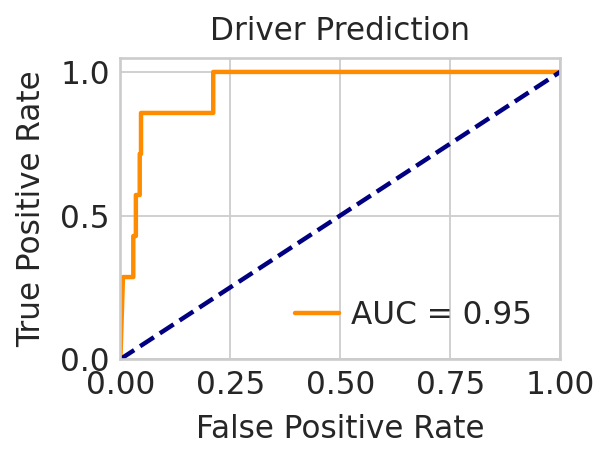

In [18]:
with mplscience.style_context():  # Entering the custom style context
    # Calculate ROC curve and AUC
    fpr, tpr, _ = roc_curve(label, score)
    roc_auc = auc(fpr, tpr)
    sns.set_style("whitegrid")
    # Create a figure and axis object with a specified size
    fig, ax = plt.subplots(figsize=(4, 3))

    # Plot ROC curve
    ax.plot(fpr, tpr, color="darkorange", lw=2, label=f"AUC = {roc_auc:.2f}")

    # Plot diagonal line (random guess line)
    ax.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
    # Set limits for x and y axes
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    # Set labels, title, and ticks with specified font sizes
    ax.set_xlabel("False Positive Rate", fontsize=14)
    ax.set_ylabel("True Positive Rate", fontsize=14)
    ax.set_title("Driver Prediction", fontsize=14)
    ax.tick_params(axis="both", which="major", labelsize=14)

    # Add legend
    ax.legend(loc="lower right", fontsize=14)
    # Adjust layout to fit the elements within the figure area
    plt.tight_layout()
    # Save figure if SAVE_FIGURES is True
    if SAVE_FIGURES:
        save_path = FIG_DIR / "pancreatic_endocrine" / "TF_perturbation" / "ROC_curve.svg"
        fig.savefig(save_path, format="svg", transparent=True, bbox_inches="tight")

## Load original perturbation prediction results to reproduce results in manuscript

In [19]:
## Rep-1
coef = pd.read_csv("RegVelo_datasets/pancreatic endocrine/TF_perturbation/coef_0", index_col=0)
coef2 = pd.read_csv("RegVelo_datasets/pancreatic endocrine/TF_perturbation/coef_1", index_col=0)
coef3 = pd.read_csv("RegVelo_datasets/pancreatic endocrine/TF_perturbation/coef_2", index_col=0)
coef4 = pd.read_csv("RegVelo_datasets/pancreatic endocrine/TF_perturbation/coef_3", index_col=0)
coef5 = pd.read_csv("RegVelo_datasets/pancreatic endocrine/TF_perturbation/coef_4", index_col=0)

## Rep-2
coef6 = pd.read_csv("RegVelo_datasets/pancreatic endocrine/TF_perturbation/coef_5", index_col=0)
coef7 = pd.read_csv("RegVelo_datasets/pancreatic endocrine/TF_perturbation/coef_6", index_col=0)
coef8 = pd.read_csv("RegVelo_datasets/pancreatic endocrine/TF_perturbation/coef_7", index_col=0)
coef9 = pd.read_csv("RegVelo_datasets/pancreatic endocrine/TF_perturbation/coef_8", index_col=0)
coef10 = pd.read_csv("RegVelo_datasets/pancreatic endocrine/TF_perturbation/coef_9", index_col=0)

## Rep-3
coef11 = pd.read_csv("RegVelo_datasets/pancreatic endocrine/TF_perturbation/coef_10", index_col=0)
coef12 = pd.read_csv("RegVelo_datasets/pancreatic endocrine/TF_perturbation/coef_11", index_col=0)
coef13 = pd.read_csv("RegVelo_datasets/pancreatic endocrine/TF_perturbation/coef_12", index_col=0)
coef14 = pd.read_csv("RegVelo_datasets/pancreatic endocrine/TF_perturbation/coef_13", index_col=0)
coef15 = pd.read_csv("RegVelo_datasets/pancreatic endocrine/TF_perturbation/coef_14", index_col=0)

## Rep-4
coef16 = pd.read_csv("RegVelo_datasets/pancreatic endocrine/TF_perturbation/coef_15", index_col=0)
coef17 = pd.read_csv("RegVelo_datasets/pancreatic endocrine/TF_perturbation/coef_16", index_col=0)
coef18 = pd.read_csv("RegVelo_datasets/pancreatic endocrine/TF_perturbation/coef_17", index_col=0)
coef19 = pd.read_csv("RegVelo_datasets/pancreatic endocrine/TF_perturbation/coef_18", index_col=0)
coef20 = pd.read_csv("RegVelo_datasets/pancreatic endocrine/TF_perturbation/coef_19", index_col=0)

## Rep-5
coef21 = pd.read_csv("RegVelo_datasets/pancreatic endocrine/TF_perturbation/coef_20", index_col=0)
coef22 = pd.read_csv("RegVelo_datasets/pancreatic endocrine/TF_perturbation/coef_21", index_col=0)
coef23 = pd.read_csv("RegVelo_datasets/pancreatic endocrine/TF_perturbation/coef_22", index_col=0)
coef24 = pd.read_csv("RegVelo_datasets/pancreatic endocrine/TF_perturbation/coef_23", index_col=0)
coef25 = pd.read_csv("RegVelo_datasets/pancreatic endocrine/TF_perturbation/coef_24", index_col=0)

In [20]:
dfs = [coef, coef2, coef3, coef4, coef5]
# Compute the median across corresponding entries
coef_new = pd.concat(dfs).groupby(level=0).median()

dfs = [coef6, coef7, coef8, coef9, coef10]
# Compute the median across corresponding entries
coef_new2 = pd.concat(dfs).groupby(level=0).median()

dfs = [coef11, coef12, coef13, coef14, coef15]
# Compute the median across corresponding entries
coef_new3 = pd.concat(dfs).groupby(level=0).median()

dfs = [coef16, coef17, coef18, coef19, coef20]
# Compute the median across corresponding entries
coef_new4 = pd.concat(dfs).groupby(level=0).median()

dfs = [coef21, coef22, coef23, coef24, coef25]
# Compute the median across corresponding entries
coef_new5 = pd.concat(dfs).groupby(level=0).median()

In [21]:
## plot the correlation boxplot
coef_new.columns = coef_new.columns + "_1"
coef_new2.columns = coef_new2.columns + "_2"
coef_new3.columns = coef_new3.columns + "_3"
coef_new4.columns = coef_new4.columns + "_4"
coef_new5.columns = coef_new5.columns + "_5"

In [22]:
combined_df = pd.concat([coef_new, coef_new2, coef_new3, coef_new4, coef_new5], axis=1)

correlation_results = {}
for metric in ["Alpha", "Beta", "Delta", "Epsilon"]:  # Assuming there are 4 metrics
    metric_cols = [f"{metric}_{i}" for i in range(1, 6)]
    metric_df = combined_df[metric_cols]
    correlation_results[f"{metric}"] = metric_df.corr()

In [23]:
groups = ["Alpha", "Beta", "Delta", "Epsilon"]
upper_triangle_parts = [[] for _ in range(4)]  # Assuming there are 4 metrics

# Extract upper triangle part for each metric
idx = 0
for metric_idx in groups:  # Assuming there are 4 metrics
    correlation_matrix = correlation_results[f"{metric_idx}"]
    upper_triangle = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(np.bool))
    upper_triangle_parts[idx] = upper_triangle.stack()
    idx += 1

# Create DataFrame with concatenated upper triangle parts and group column
df_concatenated = pd.DataFrame(
    {
        "Correlation": upper_triangle_parts[0].tolist()
        + upper_triangle_parts[1].tolist()
        + upper_triangle_parts[2].tolist()
        + upper_triangle_parts[3].tolist(),
        "Group": np.repeat(groups, len(upper_triangle_parts[0])),
    }
)

## Visualization perturbation identifiability

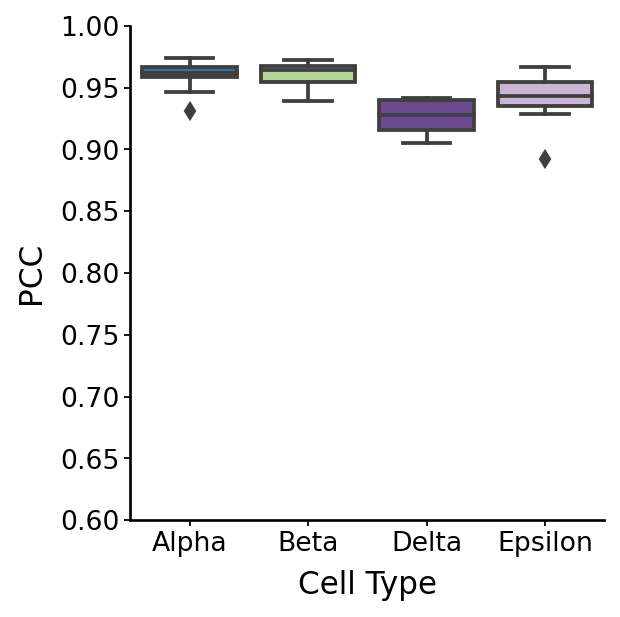

In [24]:
palette = dict(zip(reg_bdata.obs["clusters"].cat.categories, reg_bdata.uns["clusters_colors"]))

with mplscience.style_context():
    fig, ax = plt.subplots(figsize=(4, 4))

    sns.boxplot(data=df_concatenated, x="Group", y="Correlation", palette=palette, ax=ax)

    plt.xlabel("Cell Type")
    plt.ylabel("PCC")
    plt.ylim(0.6, 1)
    plt.tight_layout()
    plt.show()

## Benchmark cell fate and velocity identifiability

In [25]:
## calculate fate probability
model = DATA_DIR / "pancreatic_endocrine" / "perturb_repeat_runs" / "rgv_model_0"
### load model
reg_vae = REGVELOVI.load(model, reg_bdata)
# grn5 = reg_vae.module.v_encoder.fc1.weight.data.cpu().detach().clone()
adata_target = add_regvelo_outputs_to_adata(reg_bdata, reg_vae)

model = DATA_DIR / "pancreatic_endocrine" / "perturb_repeat_runs" / "rgv_model_1"
### load model
reg_vae = REGVELOVI.load(model, reg_bdata)
# grn6 = reg_vae.module.v_encoder.fc1.weight.data.cpu().detach().clone()
adata_target2 = add_regvelo_outputs_to_adata(reg_bdata, reg_vae)

model = DATA_DIR / "pancreatic_endocrine" / "perturb_repeat_runs" / "rgv_model_2"
### load model
reg_vae = REGVELOVI.load(model, reg_bdata)
# grn7 = reg_vae.module.v_encoder.fc1.weight.data.cpu().detach().clone()
adata_target3 = add_regvelo_outputs_to_adata(reg_bdata, reg_vae)

model = DATA_DIR / "pancreatic_endocrine" / "perturb_repeat_runs" / "rgv_model_3"
### load model
reg_vae = REGVELOVI.load(model, reg_bdata)
# grn8 = reg_vae.module.v_encoder.fc1.weight.data.cpu().detach().clone()
adata_target4 = add_regvelo_outputs_to_adata(reg_bdata, reg_vae)

model = DATA_DIR / "pancreatic_endocrine" / "perturb_repeat_runs" / "rgv_model_4"
### load model
reg_vae = REGVELOVI.load(model, reg_bdata)
adata_target5 = add_regvelo_outputs_to_adata(reg_bdata, reg_vae)

INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_0/model.pt already downloaded                                                         
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_1/model.pt already downloaded                                                         
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_2/model.pt already downloaded              

In [26]:
stacked_arrays = np.stack(
    (
        adata_target.layers["velocity"],
        adata_target2.layers["velocity"],
        adata_target3.layers["velocity"],
        adata_target4.layers["velocity"],
        adata_target5.layers["velocity"],
    ),
    axis=2,
)

# Calculate pairwise cell correlation among two arrays
correlations = []
for i in range(stacked_arrays.shape[2] + 1):
    for j in range(i + 1, (stacked_arrays.shape[2])):
        if i != j:
            correlation_matrix = np.corrcoef(stacked_arrays[:, :, i], stacked_arrays[:, :, j])
            # Extract upper triangle part (excluding diagonal)
            correlation_matrix = correlation_matrix[
                0 : adata_target.layers["velocity"].shape[0],
                adata_target.layers["velocity"].shape[0] : (2 * adata_target.layers["velocity"].shape[0]),
            ]
            corr1 = np.diag(correlation_matrix)
            corr1 = [
                np.mean(np.array(corr1)[adata_target.obs["clusters"] == "Alpha"]),
                np.mean(np.array(corr1)[adata_target.obs["clusters"] == "Beta"]),
                np.mean(np.array(corr1)[adata_target.obs["clusters"] == "Delta"]),
                np.mean(np.array(corr1)[adata_target.obs["clusters"] == "Epsilon"]),
            ]
            correlations.append(corr1)

In [27]:
correlations = np.array(correlations)

In [28]:
groups = ["Alpha", "Beta", "Delta", "Epsilon"]
df = pd.DataFrame(
    {
        "Correlation": correlations[:, 0].tolist()
        + correlations[:, 1].tolist()
        + correlations[:, 2].tolist()
        + correlations[:, 3].tolist(),
        "Group": np.repeat(groups, correlations.shape[0]),
    }
)

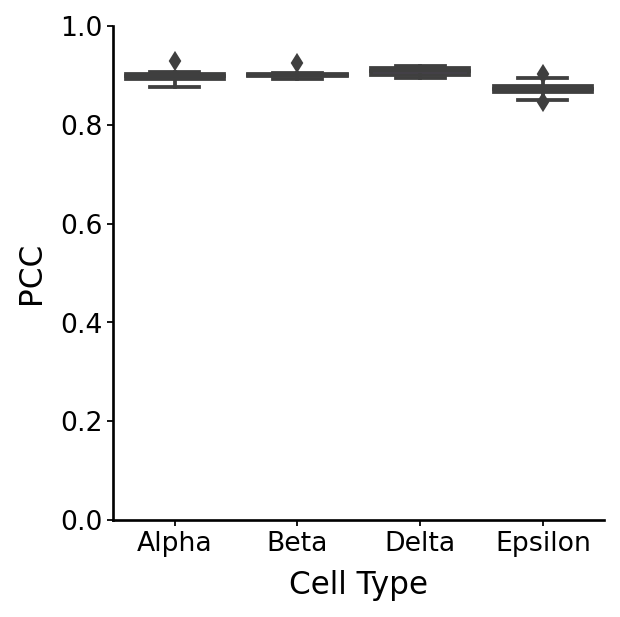

In [29]:
palette = dict(zip(reg_bdata.obs["clusters"].cat.categories, reg_bdata.uns["clusters_colors"]))

with mplscience.style_context():
    fig, ax = plt.subplots(figsize=(4, 4))

    sns.boxplot(data=df, x="Group", y="Correlation", palette=palette, ax=ax)

    plt.xlabel("Cell Type")
    plt.ylabel("PCC")
    plt.ylim(0, 1)
    plt.tight_layout()
    plt.show()

In [30]:
fate1 = cal_cell_fate(adata_target, terminal_states=groups, cluster_key="clusters", n_states=8)
fate2 = cal_cell_fate(adata_target2, terminal_states=groups, cluster_key="clusters", n_states=8)
fate3 = cal_cell_fate(adata_target3, terminal_states=groups, cluster_key="clusters", n_states=8)
fate4 = cal_cell_fate(adata_target4, terminal_states=groups, cluster_key="clusters", n_states=8)
fate5 = cal_cell_fate(adata_target5, terminal_states=groups, cluster_key="clusters", n_states=8)

  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 


  0%|          | 0/3696 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 11 SEGV: Segmentation Violation, probably memory access out of range
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
[0]PE

  0%|          | 0/3696 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 11 SEGV: Segmentation Violation, probably memory access out of range
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
[0]PE

  0%|          | 0/3696 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.


  0%|          | 0/3696 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.


  0%|          | 0/3696 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 11 SEGV: Segmentation Violation, probably memory access out of range
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
[0]PE

  0%|          | 0/3696 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 11 SEGV: Segmentation Violation, probably memory access out of range
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: [0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC

  0%|          | 0/3696 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.


In [31]:
## plot the correlation boxplot
fate1.columns = fate1.columns + "_1"
fate2.columns = fate2.columns + "_2"
fate3.columns = fate3.columns + "_3"
fate4.columns = fate4.columns + "_4"
fate5.columns = fate5.columns + "_5"

In [32]:
combined_df = pd.concat([fate1, fate2, fate3, fate4, fate5], axis=1)

correlation_results = {}
for metric in ["Alpha", "Beta", "Delta", "Epsilon"]:  # Assuming there are 4 metrics
    metric_cols = [f"{metric}_{i}" for i in range(1, 6)]
    metric_df = combined_df[metric_cols]
    correlation_results[f"{metric}"] = metric_df.corr()

In [33]:
groups = ["Alpha", "Beta", "Delta", "Epsilon"]
upper_triangle_parts = [[] for _ in range(4)]  # Assuming there are 4 metrics
idx = 0
for metric_idx in groups:  # Assuming there are 4 metrics
    correlation_matrix = correlation_results[f"{metric_idx}"]
    upper_triangle = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(np.bool))
    upper_triangle_parts[idx] = upper_triangle.stack()
    idx += 1
df_concatenated2 = pd.DataFrame(
    {
        "Correlation": upper_triangle_parts[0].tolist()
        + upper_triangle_parts[1].tolist()
        + upper_triangle_parts[2].tolist()
        + upper_triangle_parts[3].tolist(),
        "Group": np.repeat(groups, len(upper_triangle_parts[0])),
    }
)

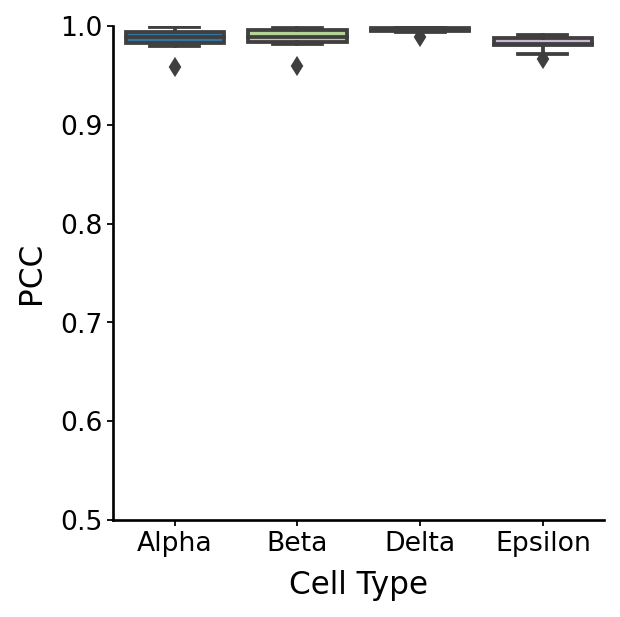

In [34]:
palette = dict(zip(reg_bdata.obs["clusters"].cat.categories, reg_bdata.uns["clusters_colors"]))

with mplscience.style_context():
    fig, ax = plt.subplots(figsize=(4, 4))

    sns.boxplot(data=df_concatenated2, x="Group", y="Correlation", palette=palette, ax=ax)

    plt.xlabel("Cell Type")
    plt.ylabel("PCC")
    plt.ylim(0.5, 1)
    plt.tight_layout()
    plt.show()

## Reproduce the result in manuscript

In [35]:
adata_target = sc.read_h5ad("RegVelo_datasets/pancreatic endocrine/TF_perturbation/adata_target.h5ad")
adata_target2 = sc.read_h5ad("RegVelo_datasets/pancreatic endocrine/TF_perturbation/adata_target2.h5ad")
adata_target3 = sc.read_h5ad("RegVelo_datasets/pancreatic endocrine/TF_perturbation/adata_target3.h5ad")
adata_target4 = sc.read_h5ad("RegVelo_datasets/pancreatic endocrine/TF_perturbation/adata_target4.h5ad")
adata_target5 = sc.read_h5ad("RegVelo_datasets/pancreatic endocrine/TF_perturbation/adata_target5.h5ad")

In [36]:
stacked_arrays = np.stack(
    (
        adata_target.layers["velocity"],
        adata_target2.layers["velocity"],
        adata_target3.layers["velocity"],
        adata_target4.layers["velocity"],
        adata_target5.layers["velocity"],
    ),
    axis=2,
)

# Calculate pairwise cell correlation among two arrays
correlations = []
for i in range(stacked_arrays.shape[2] + 1):
    for j in range(i + 1, (stacked_arrays.shape[2])):
        if i != j:
            correlation_matrix = np.corrcoef(stacked_arrays[:, :, i], stacked_arrays[:, :, j])
            # Extract upper triangle part (excluding diagonal)
            correlation_matrix = correlation_matrix[
                0 : adata_target.layers["velocity"].shape[0],
                adata_target.layers["velocity"].shape[0] : (2 * adata_target.layers["velocity"].shape[0]),
            ]
            corr1 = np.diag(correlation_matrix)
            corr1 = [
                np.mean(np.array(corr1)[adata_target.obs["clusters"] == "Alpha"]),
                np.mean(np.array(corr1)[adata_target.obs["clusters"] == "Beta"]),
                np.mean(np.array(corr1)[adata_target.obs["clusters"] == "Delta"]),
                np.mean(np.array(corr1)[adata_target.obs["clusters"] == "Epsilon"]),
            ]
            correlations.append(corr1)

In [37]:
correlations = np.array(correlations)

In [38]:
groups = ["Alpha", "Beta", "Delta", "Epsilon"]
df = pd.DataFrame(
    {
        "Correlation": correlations[:, 0].tolist()
        + correlations[:, 1].tolist()
        + correlations[:, 2].tolist()
        + correlations[:, 3].tolist(),
        "Group": np.repeat(groups, correlations.shape[0]),
    }
)

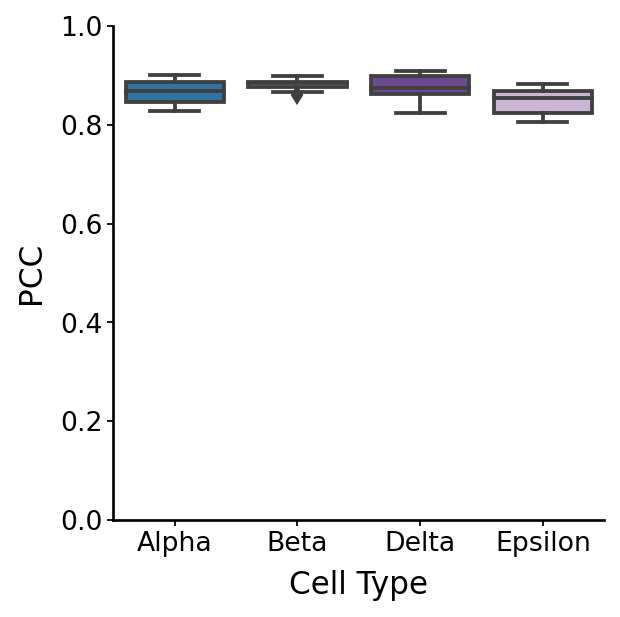

In [39]:
palette = dict(zip(reg_bdata.obs["clusters"].cat.categories, reg_bdata.uns["clusters_colors"]))

with mplscience.style_context():
    fig, ax = plt.subplots(figsize=(4, 4))

    sns.boxplot(data=df, x="Group", y="Correlation", palette=palette, ax=ax)

    plt.xlabel("Cell Type")
    plt.ylabel("PCC")
    plt.ylim(0, 1)
    plt.tight_layout()
    plt.show()

In [40]:
groups = ["Alpha", "Beta", "Delta", "Epsilon"]
fate1 = cal_cell_fate(adata_target, terminal_states=groups, cluster_key="clusters", n_states=8)
fate2 = cal_cell_fate(adata_target2, terminal_states=groups, cluster_key="clusters", n_states=8)
fate3 = cal_cell_fate(adata_target3, terminal_states=groups, cluster_key="clusters", n_states=8)
fate4 = cal_cell_fate(adata_target4, terminal_states=groups, cluster_key="clusters", n_states=8)
fate5 = cal_cell_fate(adata_target5, terminal_states=groups, cluster_key="clusters", n_states=8)

  0%|          | 0/3696 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.


  0%|          | 0/3696 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.


  0%|          | 0/3696 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.


  0%|          | 0/3696 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.


  0%|          | 0/3696 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.


  0%|          | 0/3696 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.


  0%|          | 0/3696 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.


  0%|          | 0/3696 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: 

  0%|          | 0/3696 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.


  0%|          | 0/3696 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.


In [41]:
## plot the correlation boxplot
fate1.columns = fate1.columns + "_1"
fate2.columns = fate2.columns + "_2"
fate3.columns = fate3.columns + "_3"
fate4.columns = fate4.columns + "_4"
fate5.columns = fate5.columns + "_5"

In [42]:
combined_df = pd.concat([fate1, fate2, fate3, fate4, fate5], axis=1)

correlation_results = {}
for metric in ["Alpha", "Beta", "Delta", "Epsilon"]:  # Assuming there are 4 metrics
    metric_cols = [f"{metric}_{i}" for i in range(1, 6)]
    metric_df = combined_df[metric_cols]
    correlation_results[f"{metric}"] = metric_df.corr()

In [43]:
groups = ["Alpha", "Beta", "Delta", "Epsilon"]
upper_triangle_parts = [[] for _ in range(4)]  # Assuming there are 4 metrics
idx = 0
for metric_idx in groups:  # Assuming there are 4 metrics
    correlation_matrix = correlation_results[f"{metric_idx}"]
    upper_triangle = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(np.bool))
    upper_triangle_parts[idx] = upper_triangle.stack()
    idx += 1
df_concatenated2 = pd.DataFrame(
    {
        "Correlation": upper_triangle_parts[0].tolist()
        + upper_triangle_parts[1].tolist()
        + upper_triangle_parts[2].tolist()
        + upper_triangle_parts[3].tolist(),
        "Group": np.repeat(groups, len(upper_triangle_parts[0])),
    }
)

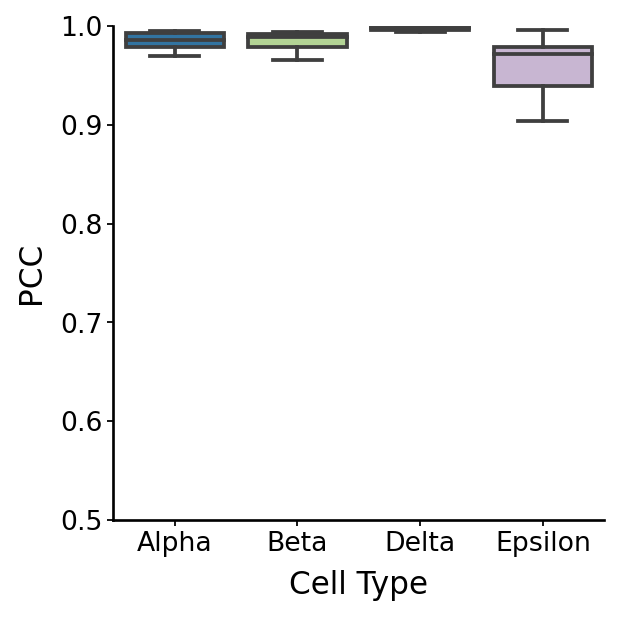

In [44]:
palette = dict(zip(reg_bdata.obs["clusters"].cat.categories, reg_bdata.uns["clusters_colors"]))

with mplscience.style_context():
    fig, ax = plt.subplots(figsize=(4, 4))

    sns.boxplot(data=df_concatenated2, x="Group", y="Correlation", palette=palette, ax=ax)

    plt.xlabel("Cell Type")
    plt.ylabel("PCC")
    plt.ylim(0.5, 1)
    plt.tight_layout()
    plt.show()

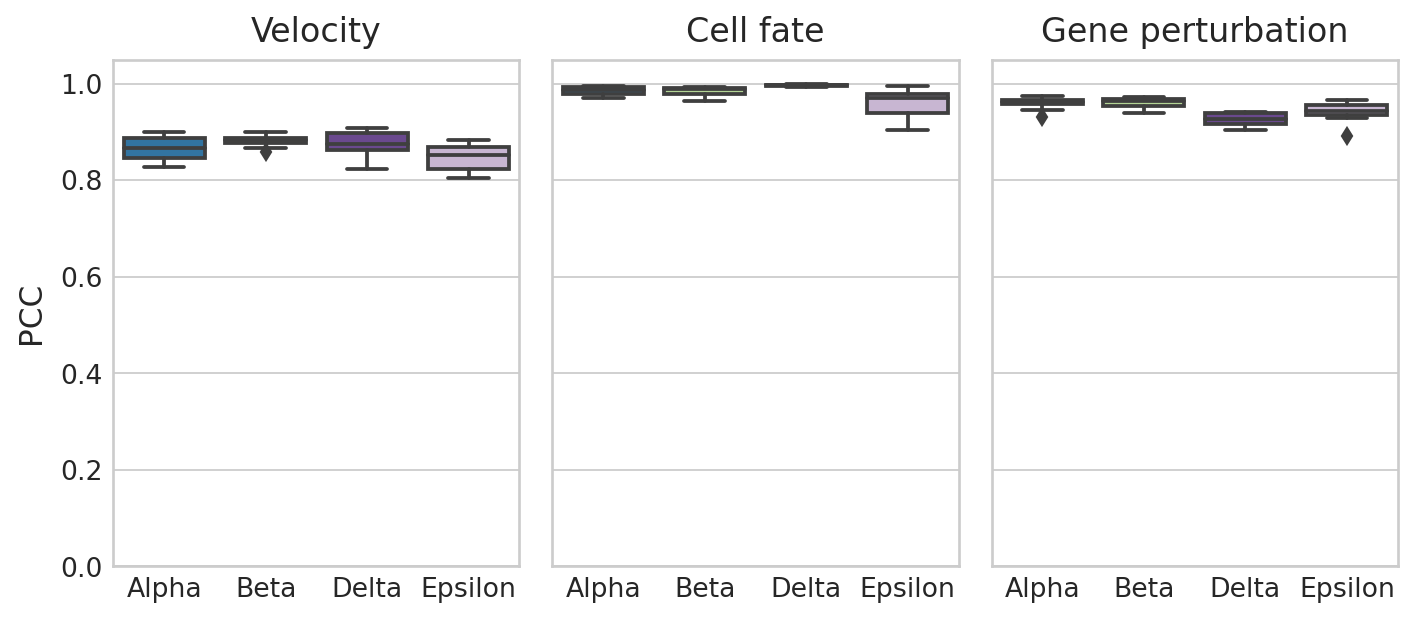

In [45]:
# Create figure with two subplots
with mplscience.style_context():  # Entering the custom style context
    sns.set_style("whitegrid")
    fig, axes = plt.subplots(1, 3, figsize=(9, 4), sharey=True)  # 1 row, 2 columns

    # Loop over the subplots and plot data for each run
    ax = axes[0]
    sns.boxplot(y="Correlation", x="Group", data=df, ax=ax, palette=palette)
    ax.set_title("Velocity")
    ax.set_xlabel("")
    ax.set_ylabel("PCC")

    ax = axes[1]
    sns.boxplot(y="Correlation", x="Group", data=df_concatenated2, ax=ax, palette=palette)
    ax.set_title("Cell fate")
    ax.set_xlabel("")
    ax.set_ylabel("")

    ax = axes[2]
    sns.boxplot(y="Correlation", x="Group", data=df_concatenated, ax=ax, palette=palette)
    ax.set_title("Gene perturbation")
    ax.set_xlabel("")
    ax.set_ylabel("")

    # Set a common ylabel
    axes[0].set_ylabel("PCC")
    plt.ylim(0, 1.05)

    # Show the plot
    plt.tight_layout()

    if SAVE_FIGURES:
        save_path = FIG_DIR / "pancreatic_endocrine" / "TF_perturbation" / "Identifiability_Benchmark.svg"
        fig.savefig(save_path, format="svg", transparent=True, bbox_inches="tight")

## Apply veloVI as the baseline

In [46]:
### repeat run veloVI model
VELOVI.setup_anndata(reg_bdata, spliced_layer="Ms", unspliced_layer="Mu")
vae1 = VELOVI(reg_bdata)
vae1.train()

VELOVI.setup_anndata(reg_bdata, spliced_layer="Ms", unspliced_layer="Mu")
vae2 = VELOVI(reg_bdata)
vae2.train()

VELOVI.setup_anndata(reg_bdata, spliced_layer="Ms", unspliced_layer="Mu")
vae3 = VELOVI(reg_bdata)
vae3.train()

VELOVI.setup_anndata(reg_bdata, spliced_layer="Ms", unspliced_layer="Mu")
vae4 = VELOVI(reg_bdata)
vae4.train()

VELOVI.setup_anndata(reg_bdata, spliced_layer="Ms", unspliced_layer="Mu")
vae5 = VELOVI(reg_bdata)
vae5.train()

/home/icb/weixu.wang/miniconda3/envs/RegVelo/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/RegVelo/lib/pyt ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/icb/weixu.wang/miniconda3/envs/RegVelo/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/RegVelo/lib/pyt ...
  rank_zero_warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 343/500:  69%|██████▊   | 343/500 [01:18<00:35,  4.36it/s, loss=-2.86e+03, v_num=1]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: -2736.853. Signaling Trainer to stop.


/home/icb/weixu.wang/miniconda3/envs/RegVelo/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/RegVelo/lib/pyt ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/icb/weixu.wang/miniconda3/envs/RegVelo/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/RegVelo/lib/pyt ...
  rank_zero_warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 448/500:  90%|████████▉ | 448/500 [01:41<00:11,  4.43it/s, loss=-2.88e+03, v_num=1]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: -2739.015. Signaling Trainer to stop.


/home/icb/weixu.wang/miniconda3/envs/RegVelo/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/RegVelo/lib/pyt ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/icb/weixu.wang/miniconda3/envs/RegVelo/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/RegVelo/lib/pyt ...
  rank_zero_warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 302/500:  60%|██████    | 302/500 [01:08<00:45,  4.39it/s, loss=-2.84e+03, v_num=1]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: -2723.306. Signaling Trainer to stop.


/home/icb/weixu.wang/miniconda3/envs/RegVelo/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/RegVelo/lib/pyt ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/icb/weixu.wang/miniconda3/envs/RegVelo/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/RegVelo/lib/pyt ...
  rank_zero_warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 500/500: 100%|██████████| 500/500 [01:54<00:00,  4.13it/s, loss=-2.89e+03, v_num=1]

`Trainer.fit` stopped: `max_epochs=500` reached.


Epoch 500/500: 100%|██████████| 500/500 [01:54<00:00,  4.36it/s, loss=-2.89e+03, v_num=1]


/home/icb/weixu.wang/miniconda3/envs/RegVelo/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/RegVelo/lib/pyt ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/icb/weixu.wang/miniconda3/envs/RegVelo/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/RegVelo/lib/pyt ...
  rank_zero_warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 367/500:  73%|███████▎  | 367/500 [01:23<00:30,  4.41it/s, loss=-2.86e+03, v_num=1]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: -2737.856. Signaling Trainer to stop.


In [47]:
adata_velovi = adata_target.copy()
add_outputs_to_adata(adata_velovi, vae1)
adata_velovi2 = adata_target.copy()
add_outputs_to_adata(adata_velovi2, vae2)
adata_velovi3 = adata_target.copy()
add_outputs_to_adata(adata_velovi3, vae3)
adata_velovi4 = adata_target.copy()
add_outputs_to_adata(adata_velovi4, vae4)
adata_velovi5 = adata_target.copy()
add_outputs_to_adata(adata_velovi5, vae5)

In [48]:
fate1 = cal_cell_fate(adata_velovi, terminal_states=["Alpha", "Beta", "Delta"], cluster_key="clusters", n_states=8)
fate2 = cal_cell_fate(adata_velovi2, terminal_states=["Alpha", "Beta", "Delta"], cluster_key="clusters", n_states=8)
fate3 = cal_cell_fate(adata_velovi3, terminal_states=["Alpha", "Beta", "Delta"], cluster_key="clusters", n_states=8)
fate4 = cal_cell_fate(adata_velovi4, terminal_states=["Alpha", "Beta", "Delta"], cluster_key="clusters", n_states=8)
fate5 = cal_cell_fate(adata_velovi5, terminal_states=["Alpha", "Beta", "Delta"], cluster_key="clusters", n_states=8)

  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

In [49]:
## plot the correlation boxplot
fate1.columns = fate1.columns + "_1"
fate2.columns = fate2.columns + "_2"
fate3.columns = fate3.columns + "_3"
fate4.columns = fate4.columns + "_4"
fate5.columns = fate5.columns + "_5"

In [50]:
combined_df = pd.concat([fate1, fate2, fate3, fate4, fate5], axis=1)

correlation_results = {}
for metric in ["Alpha", "Beta", "Delta"]:  # Assuming there are 4 metrics
    metric_cols = [f"{metric}_{i}" for i in range(1, 6)]
    metric_df = combined_df[metric_cols]
    correlation_results[f"{metric}"] = metric_df.corr()

In [51]:
groups = ["Alpha", "Beta", "Delta"]

# Assuming you have the correlation_results dictionary containing the correlation matrices for each metric

# Initialize empty lists to store upper triangle parts
upper_triangle_parts = [[] for _ in range(4)]  # Assuming there are 4 metrics

# Extract upper triangle part for each metric
idx = 0
for metric_idx in groups:  # Assuming there are 4 metrics
    correlation_matrix = correlation_results[f"{metric_idx}"]
    upper_triangle = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(np.bool))
    upper_triangle_parts[idx] = upper_triangle.stack()
    idx += 1

# Create DataFrame with concatenated upper triangle parts and group column
df_concatenated3 = pd.DataFrame(
    {
        "Correlation": upper_triangle_parts[0].tolist()
        + upper_triangle_parts[1].tolist()
        + upper_triangle_parts[2].tolist(),
        "Group": np.repeat(groups[0], len(upper_triangle_parts[0].tolist())).tolist()
        + np.repeat(groups[1], len(upper_triangle_parts[1].tolist())).tolist()
        + np.repeat(groups[2], len(upper_triangle_parts[2].tolist())).tolist(),
    }
)

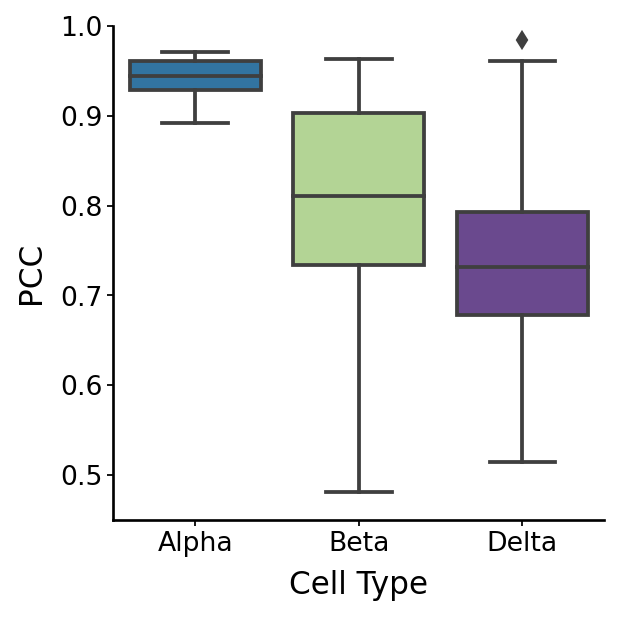

In [52]:
palette = dict(zip(reg_bdata.obs["clusters"].cat.categories, reg_bdata.uns["clusters_colors"]))
with mplscience.style_context():
    fig, ax = plt.subplots(figsize=(4, 4))

    sns.boxplot(data=df_concatenated3, x="Group", y="Correlation", palette=palette, ax=ax)

    plt.xlabel("Cell Type")
    plt.ylabel("PCC")
    plt.ylim(0.45, 1)
    plt.tight_layout()
    plt.show()

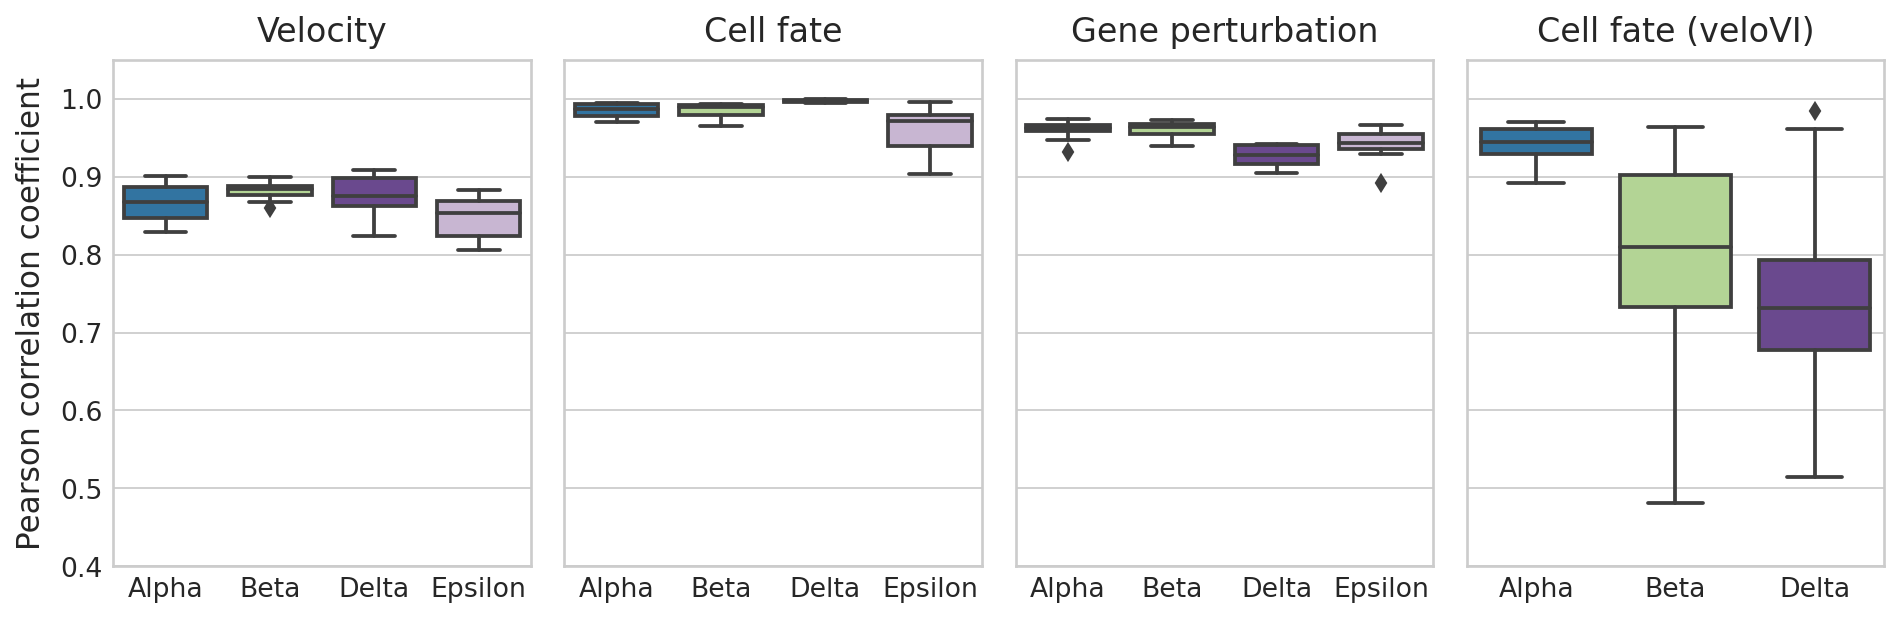

In [53]:
with mplscience.style_context():  # Entering the custom style context
    sns.set_style("whitegrid")
    fig, axes = plt.subplots(1, 4, figsize=(12, 4), sharey=True)  # 1 row, 2 columns
    plt.rcParams["svg.fonttype"] = "none"
    # Loop over the subplots and plot data for each run
    ax = axes[0]
    sns.boxplot(y="Correlation", x="Group", data=df, ax=ax, palette=palette)
    ax.set_title("Velocity")
    ax.set_xlabel("")
    ax.set_ylabel("PCC")

    ax = axes[1]
    sns.boxplot(y="Correlation", x="Group", data=df_concatenated2, ax=ax, palette=palette)
    ax.set_title("Cell fate")
    ax.set_xlabel("")
    ax.set_ylabel("")

    ax = axes[2]
    sns.boxplot(y="Correlation", x="Group", data=df_concatenated, ax=ax, palette=palette)
    ax.set_title("Gene perturbation")
    ax.set_xlabel("")
    ax.set_ylabel("")

    ax = axes[3]
    sns.boxplot(y="Correlation", x="Group", data=df_concatenated3, ax=ax, palette=palette)
    ax.set_title("Cell fate (veloVI)")
    ax.set_xlabel("")
    ax.set_ylabel("")

    # Set a common ylabel
    axes[0].set_ylabel("Pearson correlation coefficient")
    plt.ylim(0.4, 1.05)

    # Show the plot
    plt.tight_layout()

    if SAVE_FIGURES:
        save_path = FIG_DIR / "pancreatic_endocrine" / "TF_perturbation" / "Identifiability_Benchmark.svg"
        fig.savefig(save_path, format="svg", transparent=True, bbox_inches="tight")

## Visualize Neurod2

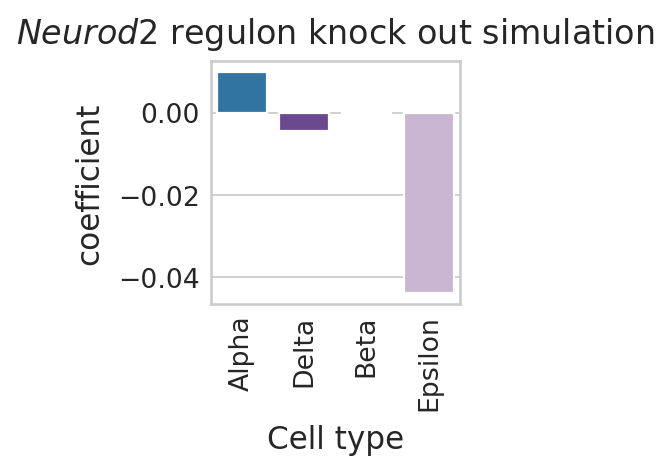

In [54]:
coef_new.columns = coef_all.columns
plot_perm_scores(coef_new, adata_target, "clusters", "Neurod2", figsize=(2, 2))
plt.show()

## Screening Neurod2 downstream targets

### Remove the model with nan output

In [55]:
coef = pd.read_csv(DATA_DIR / "pancreatic_endocrine" / "perturb_repeat_runs" / "coef_0", index_col=0).loc["Neurod2", :]
coef2 = pd.read_csv(DATA_DIR / "pancreatic_endocrine" / "perturb_repeat_runs" / "coef_1", index_col=0).loc["Neurod2", :]
coef3 = pd.read_csv(DATA_DIR / "pancreatic_endocrine" / "perturb_repeat_runs" / "coef_2", index_col=0).loc["Neurod2", :]
coef4 = pd.read_csv(DATA_DIR / "pancreatic_endocrine" / "perturb_repeat_runs" / "coef_3", index_col=0).loc["Neurod2", :]
coef5 = pd.read_csv(DATA_DIR / "pancreatic_endocrine" / "perturb_repeat_runs" / "coef_4", index_col=0).loc["Neurod2", :]

In [56]:
model_list = range(5)
model_list = np.array(model_list)[
    [
        np.isnan(coef).sum() == 0,
        np.isnan(coef2).sum() == 0,
        np.isnan(coef3).sum() == 0,
        np.isnan(coef4).sum() == 0,
        np.isnan(coef5).sum() == 0,
    ]
]

In [57]:
model_list.tolist()

[1, 2, 3, 4]

In [58]:
GRN_list = []  # Assuming there are 4 metrics

for i in model_list.tolist():
    model_name = "rgv_model_" + str(i)
    model = DATA_DIR / "pancreatic_endocrine" / "perturb_repeat_runs" / model_name
    ### load model
    reg_vae = REGVELOVI.load(model, reg_bdata)
    # grn1 = reg_vae.module.v_encoder.fc1.weight.data.cpu().detach().clone()
    GRN_list.append(
        reg_vae.module.v_encoder.GRN_Jacobian(torch.tensor(reg_bdata.layers["Ms"]).to("cuda:0").mean(0))
        .cpu()
        .detach()
        .clone()
    )

INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_1/model.pt already downloaded                                                         
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_2/model.pt already downloaded                                                         
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_3/model.pt already downloaded              

In [59]:
stacked_tensors = torch.stack(GRN_list)
# Compute the median across corresponding entries
grn_all = torch.mean(stacked_tensors, dim=0)

In [60]:
targets = grn_all[:, [i == "Neurod2" for i in adata_target.var.index]].detach().cpu().numpy()
prior = reg_vae.module.v_encoder.mask_m_raw[:, [i == "Neurod2" for i in adata_target.var.index]].detach().cpu().numpy()

In [61]:
targets = pd.DataFrame(targets, index=adata_target.var.index)
targets.loc[:, "weight"] = targets.iloc[:, 0].abs()
targets.loc[:, "prior"] = prior

### Screening from top-20 targets

In [62]:
genes = targets.sort_values("weight", ascending=False).iloc[:20, :].index.tolist()

In [63]:
model_list.tolist()

[1, 2, 3, 4]

In [64]:
terminal_states = ["Alpha", "Delta", "Beta", "Epsilon"]
for i in model_list.tolist():
    print("loading model...")
    model_name = "rgv_model_" + str(i)
    model = DATA_DIR / "pancreatic_endocrine" / "perturb_repeat_runs" / model_name

    coef_name = "coef_" + str(i)
    res_save_coef = DATA_DIR / "pancreatic_endocrine" / "Neurod2_screening_repeat_runs" / coef_name

    pval_name = "pval_" + str(i)
    res_save_pval = DATA_DIR / "pancreatic_endocrine" / "Neurod2_screening_repeat_runs" / pval_name

    print("inferring perturbation...")
    perturb_screening = RegulationScanning(model, reg_bdata, 7, "clusters", terminal_states, "Neurod2", genes, 0)
    coef = pd.DataFrame(np.array(perturb_screening["coefficient"]))
    coef.index = perturb_screening["target"]
    coef.columns = get_list_name(perturb_screening["coefficient"][0])
    pval = pd.DataFrame(np.array(perturb_screening["pvalue"]))
    pval.index = perturb_screening["target"]
    pval.columns = get_list_name(perturb_screening["pvalue"][0])

    coef.to_csv(res_save_coef)
    pval.to_csv(res_save_pval)

loading model...
inferring perturbation...
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_1/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_1/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Dach1
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_1/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Zbtb20
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_1/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Klf7
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_1/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Hspa5
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_1/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Tagln2
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_1/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Hsf2
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_1/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done St18
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_1/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Enpp2
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_1/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Ttr
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_1/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Zfp516
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_1/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Tshz2
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_1/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Celf4
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_1/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done A1cf
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_1/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Csrp2
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_1/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Nfix
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_1/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Rfx6
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_1/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Hmga2
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_1/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Papss2
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_1/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Prkar1b
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_1/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Sim1
loading model...
inferring perturbation...
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_2/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_2/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Dach1
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_2/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Zbtb20
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_2/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Klf7
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_2/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Hspa5
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_2/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Tagln2
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_2/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Hsf2
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_2/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done St18
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_2/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Enpp2
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_2/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Ttr
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_2/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Zfp516
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_2/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Tshz2
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_2/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Celf4
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_2/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done A1cf
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_2/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Csrp2
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_2/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Nfix
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_2/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Rfx6
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_2/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Hmga2
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_2/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Papss2
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_2/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Prkar1b
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_2/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Sim1
loading model...
inferring perturbation...
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_3/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_3/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Dach1
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_3/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Zbtb20
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_3/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Klf7
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_3/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Hspa5
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_3/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Tagln2
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_3/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Hsf2
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_3/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done St18
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_3/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Enpp2
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_3/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Ttr
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_3/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Zfp516
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_3/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Tshz2
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_3/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Celf4
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_3/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done A1cf
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_3/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Csrp2
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_3/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Nfix
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_3/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Rfx6
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_3/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Hmga2
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_3/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Papss2
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_3/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Prkar1b
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_3/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Sim1
loading model...
inferring perturbation...
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_4/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_4/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Dach1
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_4/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Zbtb20
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_4/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Klf7
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_4/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Hspa5
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_4/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Tagln2
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_4/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Hsf2
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_4/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done St18
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_4/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Enpp2
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_4/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Ttr
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_4/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Zfp516
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_4/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Tshz2
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_4/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Celf4
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_4/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done A1cf
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_4/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Csrp2
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_4/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Nfix
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_4/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Rfx6
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_4/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Hmga2
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_4/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Papss2
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_4/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Prkar1b
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/pancreatic_endocrine/perturb_re
         peat_runs/rgv_model_4/model.pt already downloaded                                                         


  0%|          | 0/3696 [00:00<?, ?cell/s]

  0%|          | 0/3696 [00:00<?, ?cell/s]

Done Sim1


In [65]:
## Loading screening results
dfs = []
for i in model_list.tolist():
    coef_name = "coef_" + str(i)
    # grn1 = reg_vae.module.v_encoder.fc1.weight.data.cpu().detach().clone()
    dfs.append(
        pd.read_csv(DATA_DIR / "pancreatic_endocrine" / "Neurod2_screening_repeat_runs" / coef_name, index_col=0)
    )

In [66]:
coef_pre = pd.concat(dfs).groupby(level=0).mean()
gene_list = targets.sort_values("weight", ascending=False).iloc[:20, :].index.tolist()

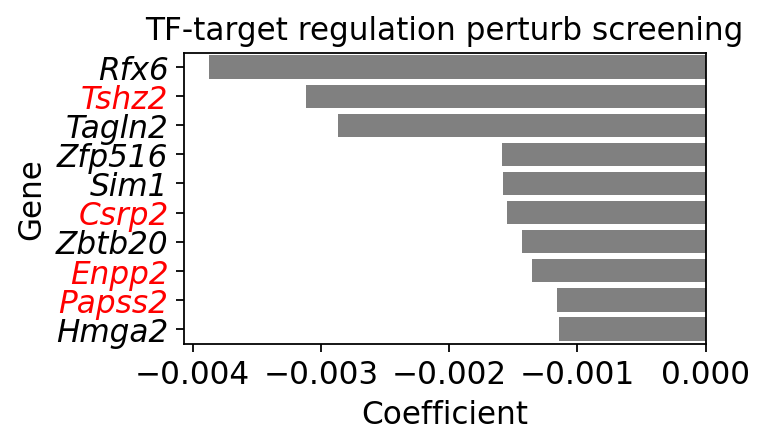

In [67]:
## rank the Epsilon prediction results
gene_scores = pd.DataFrame({"Gene": coef_pre.index.tolist(), "Score": coef_pre.loc[:, "Epsilon"]})
gene_scores.loc[:, "weights"] = gene_scores.loc[:, "Score"].abs()
# gene_scores = gene_scores.sort_values(by='weights', ascending=False).iloc[:10,:]
gene_scores = gene_scores.sort_values(by="Score", ascending=True).iloc[:10, :]

colors = [
    "red"
    if label in np.array(gene_list)[targets.sort_values("weight", ascending=False).iloc[:20, 2] == 1].tolist()
    else "black"
    for label in gene_scores.loc[:, "Gene"]
]

# Create the horizontal bar plot using Seaborn
plt.figure(figsize=(5, 3))  # Set the figure size
g = sns.barplot(x="Score", y="Gene", data=gene_scores, color="grey")

# Customize plot aesthetics
g.set_ylabel("Gene", fontsize=14)
g.set_xlabel("Coefficient", fontsize=14)

# Customize tick parameters for better readability
g.tick_params(axis="x", labelsize=14)
g.tick_params(axis="y", labelsize=14)
g.set_title("TF-target regulation perturb screening", fontsize=14)
# g.tick_params(axis = 'y', fontstyle='italic')
# g.yticks(fontsize=14, fontstyle='italic')
for _val, label in enumerate(g.get_yticklabels()):
    if (
        label.get_text()
        in np.array(gene_list)[targets.sort_values("weight", ascending=False).iloc[:20, 2] == 1].tolist()
    ):
        label.set_color("red")
    else:
        label.set_color("black")
# plt.tick_params(axis='y', colors=colors)
# Adjust layout for better fit
plt.tight_layout()
plt.setp(g.get_yticklabels(), fontstyle="italic")
plt.show()

## reproduce the results in manuscript

In [68]:
## Loading screening results
dfs = []
for i in range(5):
    coef_name = "coef_" + str(i)
    # grn1 = reg_vae.module.v_encoder.fc1.weight.data.cpu().detach().clone()
    dfs.append(pd.read_csv("RegVelo_datasets/pancreatic endocrine/Neurod2_perturbation/" + coef_name, index_col=0))

In [69]:
coef_pre = pd.concat(dfs).groupby(level=0).mean()

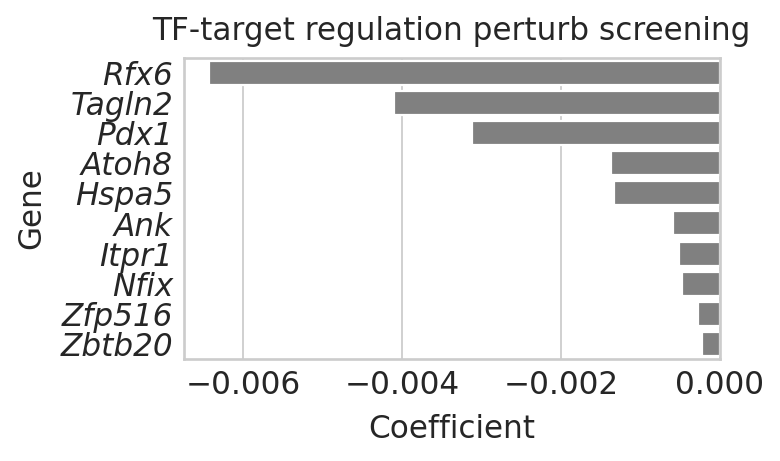

In [70]:
## rank the Epsilon prediction results
with mplscience.style_context():  # Entering the custom style context
    sns.set_style("whitegrid")
    gene_scores = pd.DataFrame({"Gene": coef_pre.index.tolist(), "Score": coef_pre.loc[:, "Epsilon"]})
    gene_scores.loc[:, "weights"] = gene_scores.loc[:, "Score"].abs()
    # gene_scores = gene_scores.sort_values(by='weights', ascending=False).iloc[:10,:]
    gene_scores = gene_scores.sort_values(by="Score", ascending=True).iloc[:10, :]
    # Create the horizontal bar plot using Seaborn
    plt.figure(figsize=(5, 3))  # Set the figure size
    g = sns.barplot(x="Score", y="Gene", data=gene_scores, color="grey")

    # Customize plot aesthetics
    g.set_ylabel("Gene", fontsize=14)
    g.set_xlabel("Coefficient", fontsize=14)

    # Customize tick parameters for better readability
    g.tick_params(axis="x", labelsize=14)
    g.tick_params(axis="y", labelsize=14)
    g.set_title("TF-target regulation perturb screening", fontsize=14)

    plt.tight_layout()
    plt.setp(g.get_yticklabels(), fontstyle="italic")

    if SAVE_FIGURES:
        save_path = FIG_DIR / "pancreatic_endocrine" / "TF_perturbation" / "Neurod2_target_screening.svg"
        fig.savefig(save_path, format="svg", transparent=True, bbox_inches="tight")

## Test Rfx6 knock-out effects

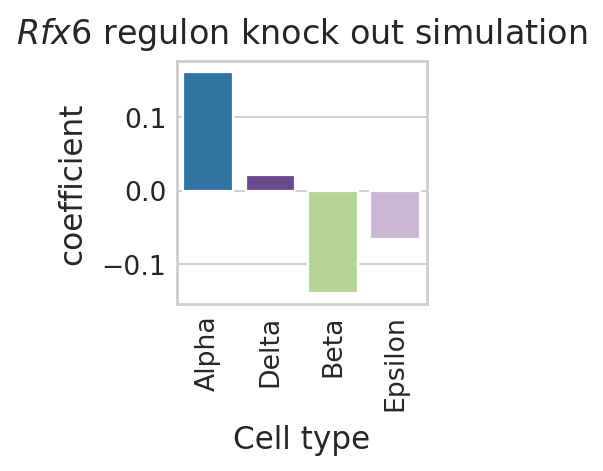

In [71]:
coef_all.columns = coef_all.columns
plot_perm_scores(coef_all, adata_target, "clusters", "Rfx6", figsize=(2, 2))
plt.show()

## reproduce the result in manuscript

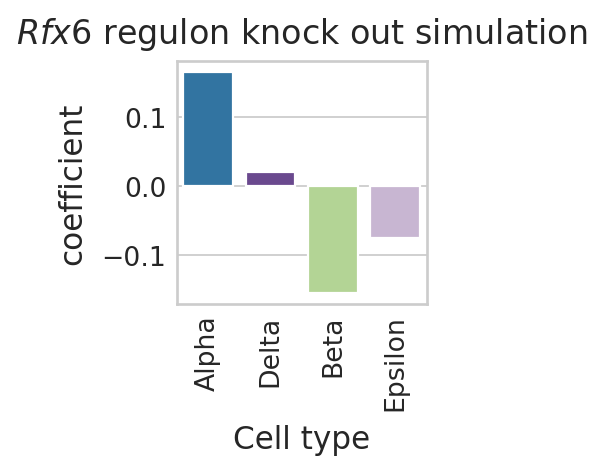

In [72]:
coef_new.columns = coef_all.columns
plot_perm_scores(coef_new, adata_target, "clusters", "Rfx6", figsize=(2, 2))
plt.show()